In [1]:
import geopandas as gpd
import pandas as pd
import ee
from src.data import mtbs
from src.data import sample_raster
import rasterio as rio
import matplotlib.pyplot as plt
from shapely.geometry import Point
from rasterio.plot import show
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
sns.set_theme()

import importlib
importlib.reload(sample_raster)


<module 'src.data.sample_raster' from '/home/jk871/fire-regen/src/data/sample_raster.py'>

In [ ]:
ee.Authenticate()

In [2]:
ee.Initialize()

In [ ]:
#gedi = pd.read_csv('/maps/fire-regen/data/seki_gedi_shots.csv', index_col=0).drop(columns=['geometry'])
gedi = pd.read_csv('/maps/fire-regen/data/sierras_gedi_shots.csv', index_col=0).drop(columns=['geometry'])
gedi.head(2)

In [ ]:
gedi_with_burn = sample_raster.sample_raster(gedi, 3)
gedi_with_burn

In [ ]:
gedi_with_burn_copy = gedi_with_burn.copy()

In [26]:
i = 0
for chunk in pd.read_csv('/maps/fire-regen/data/sierras_gedi_shots.csv', index_col=0, chunksize=500000):
    chunk = chunk.drop(columns=['geometry', 'l2_quality_flag', 'l4_quality_flag', 'degrade_flag'])
    print(f'Processing chunk {i}.')
    chunk_with_burn = sample_raster.sample_raster(chunk, 3)
    chunk_gpd = gpd.GeoDataFrame(chunk_with_burn, geometry=gpd.points_from_xy(chunk_with_burn.lon_lowestmode, chunk_with_burn.lat_lowestmode), crs=4326)
    chunk_gpd['gedi_year'] = pd.to_datetime(chunk_gpd.absolute_time, utc=True).dt.year
    chunk_gpd['time_since_burn'] = chunk_gpd.gedi_year - chunk_gpd.burn_year_sample 
    chunk_gpd.to_csv(f'/maps/fire-regen/data/sierras_matched_{i}.csv')
    i+=1
#gedi_with_burn.head(5)

Processing chunk 0.
Processing chunk 1.
Processing chunk 2.
Processing chunk 3.
Processing chunk 4.
Processing chunk 5.
Processing chunk 6.
Processing chunk 7.
Processing chunk 8.
Processing chunk 9.
Processing chunk 10.
Processing chunk 11.
Processing chunk 12.
Processing chunk 13.
Processing chunk 14.
Processing chunk 15.
Processing chunk 16.
Processing chunk 17.
Processing chunk 18.
Processing chunk 19.


In [4]:
# load chunks
gpds = []
for i in range(20):
    print(f'Processing chunk {i}')
    chunk = pd.read_csv(f'/maps/fire-regen/data/sierras_matched_{i}.csv', index_col=0)
    gpds.append(chunk)
print('Joining dataframes')
gedi_sierras = gpd.GeoDataFrame( pd.concat(gpds, ignore_index=True))
print('Writing csv file')
gedi_sierras.to_csv(f'/maps/fire-regen/data/sierras_matched_all.csv')

Processing chunk 0
Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Processing chunk 6
Processing chunk 7
Processing chunk 8
Processing chunk 9
Processing chunk 10
Processing chunk 11
Processing chunk 12
Processing chunk 13
Processing chunk 14
Processing chunk 15
Processing chunk 16
Processing chunk 17
Processing chunk 18
Processing chunk 19
Joining dataframes
Writing csv file


In [5]:
gedi_sierras.head(2)

,shot_number,absolute_time,lon_lowestmode,lat_lowestmode,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,beam_type,sensitivity,...,burn_year_std,burn_severity_median,burn_counts_3x3,burn_counts_sample,burn_counts_mean,burn_counts_std,burn_counts_median,geometry,gedi_year,time_since_burn
0,184890800200086632,2022-03-19 02:41:53.252278+00:00,-117.983310,37.034945,19.594500,2.419877,53.254089,2.981980,full,0.959151,...,0.0,0.0,[0 0 0 0 0 0 0 0 0],0,0.0,0.0,0.0,POINT (-117.9833095044786 37.0349449804212),2022,2022
1,184891100200081451,2022-03-19 02:41:53.339050+00:00,-117.985725,37.040705,17.788033,1.812951,50.249866,2.982302,full,0.966117,...,0.0,0.0,[0 0 0 0 0 0 0 0 0],0,0.0,0.0,0.0,POINT (-117.98572485904388 37.04070455654646),2022,2022


In [6]:
gedi_burn_gpd = gedi_sierras

### Process the data further

In [ ]:
# Convert to Geo Data Frame
gedi_burn_gpd = gpd.GeoDataFrame(gedi_with_burn, geometry=gpd.points_from_xy(gedi.lon_lowestmode, gedi.lat_lowestmode), crs=4326)

In [ ]:
gedi_burn_gpd['gedi_year'] = pd.to_datetime(gedi_burn_gpd.absolute_time, utc=True).dt.year
gedi_burn_gpd['time_since_burn'] = gedi_burn_gpd.gedi_year - gedi_burn_gpd.burn_year_sample

In [ ]:
gedi_burn_gpd.columns

## GEDI sampling of the time since the last burn raster

### Data filtering - based on raster - GEDI match

In [65]:
total_gedi_count = gedi_burn_gpd.shape[0]
print(f'Total number of GEDI samples in this region is: {total_gedi_count}')

Total number of GEDI samples in this region is: 9884257


We first need to eliminate GEDI samples that do not coincide with burn raster.

In [66]:
gedi_burn_gpd_no_match = gedi_burn_gpd[gedi_burn_gpd.burn_year_mean == 0]
gedi_burn_match = gedi_burn_gpd[gedi_burn_gpd.burn_year_mean != 0]
gedi_raster_match_count = gedi_burn_match.shape[0]
print(f'Number of GEDI shots that coincide with the burn raster is: {gedi_raster_match_count}, which is {((gedi_raster_match_count / total_gedi_count) * 100):.2f}% of all GEDI shots.')

Number of GEDI shots that coincide with the burn raster is: 2054382, which is 20.78% of all GEDI shots.


Get rid of shots where the data of GEDI shot happened before the fire - since we're only looking at recovery.

In [9]:
gedi_burn_match = gedi_burn_match[gedi_burn_match.time_since_burn > 0]
gedi_burn_match.shape[0]

1814996

Let's take a look at how many of these matches are homogenous 3x3 matches.

In [67]:
print(f'Number of 3x3 matches with homogenous 3x3 window of burn count: {gedi_burn_match[gedi_burn_match.burn_counts_std == 0].shape[0]}')
print(f'Number of 3x3 matches with median burn count of 1: {gedi_burn_match[gedi_burn_match.burn_counts_median == 1].shape[0]}')
print(f'Number of 3x3 matches with homogenous 3x3 window and burn count of 1: {gedi_burn_match[(gedi_burn_match.burn_counts_std == 0) & (gedi_burn_match.burn_counts_median == 1)].shape[0]}')

Number of 3x3 matches with homogenous 3x3 window of burn count: 1397597
Number of 3x3 matches with median burn count of 1: 1478924
Number of 3x3 matches with homogenous 3x3 window and burn count of 1: 1113746


In [68]:
print(f'Number of 3x3 matches with the same year of burn: {gedi_burn_match[gedi_burn_match.burn_year_std == 0].shape[0]}')
print(f'Number of 3x3 matches with the same severity of burn: {gedi_burn_match[gedi_burn_match.burn_severity_std == 0].shape[0]}')
print(f'Number of 3x3 matches with the same year and severity of burn: {gedi_burn_match[(gedi_burn_match.burn_year_std == 0) & (gedi_burn_match.burn_severity_std == 0)].shape[0]}')

Number of 3x3 matches with the same year of burn: 1941003
Number of 3x3 matches with the same severity of burn: 633089
Number of 3x3 matches with the same year and severity of burn: 631763


That means that only ~20,000 shots fall in the homogenous 3x3 raster window.

In [69]:
gedi_burn_perfect_match = gedi_burn_match[(gedi_burn_match.burn_year_std == 0) & (gedi_burn_match.burn_severity_std == 0)]
gedi_burn_imperfect_match = gedi_burn_match[(gedi_burn_match.burn_year_std == 0)]
print(gedi_burn_imperfect_match.shape[0])
print(gedi_burn_perfect_match.shape[0])

1941003
631763


In [70]:
gedi_burn_perfect_match = gedi_burn_perfect_match[(gedi_burn_perfect_match.burn_counts_median == 1) & (gedi_burn_perfect_match.burn_counts_std==0)]
gedi_burn_imperfect_match = gedi_burn_imperfect_match[(gedi_burn_imperfect_match.burn_counts_median == 1)]
print(gedi_burn_imperfect_match.shape[0])
print(gedi_burn_perfect_match.shape[0])

1455418
447497


### Recent Fires

In [72]:
gedi_burn_no_match = gedi_burn_gpd_no_match[gedi_burn_gpd_no_match.pft_class==1]
gedi_burn_no_match['time_since_burn'] = -1
gedi_all = pd.concat([gedi_burn_no_match, gedi_recent_perfect[gedi_recent_perfect.pft_class==1]])

<AxesSubplot: xlabel='burn_severity_median', ylabel='agbd'>

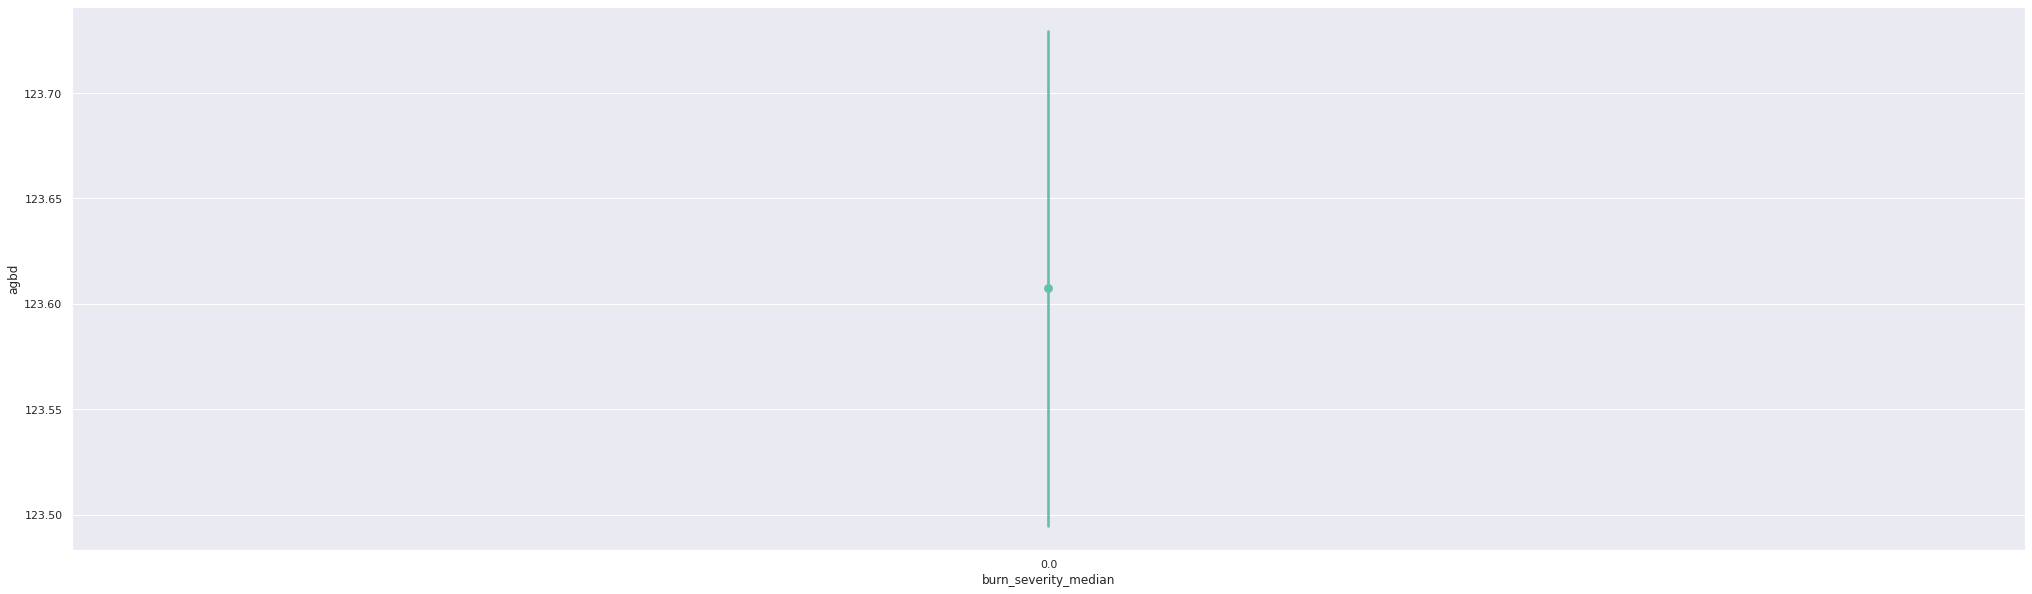

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_burn_gpd_no_match[gedi_burn_gpd_no_match.pft_class==1], x='burn_severity_median', y='agbd', palette='Set2')

In [71]:
gedi_recent_perfect = gedi_burn_perfect_match[gedi_burn_perfect_match.time_since_burn.isin([-1, 1])]
gedi_recent_imperfect = gedi_burn_imperfect_match[gedi_burn_imperfect_match.time_since_burn.isin([-1, 1])]

<AxesSubplot: xlabel='burn_severity_median', ylabel='agbd'>

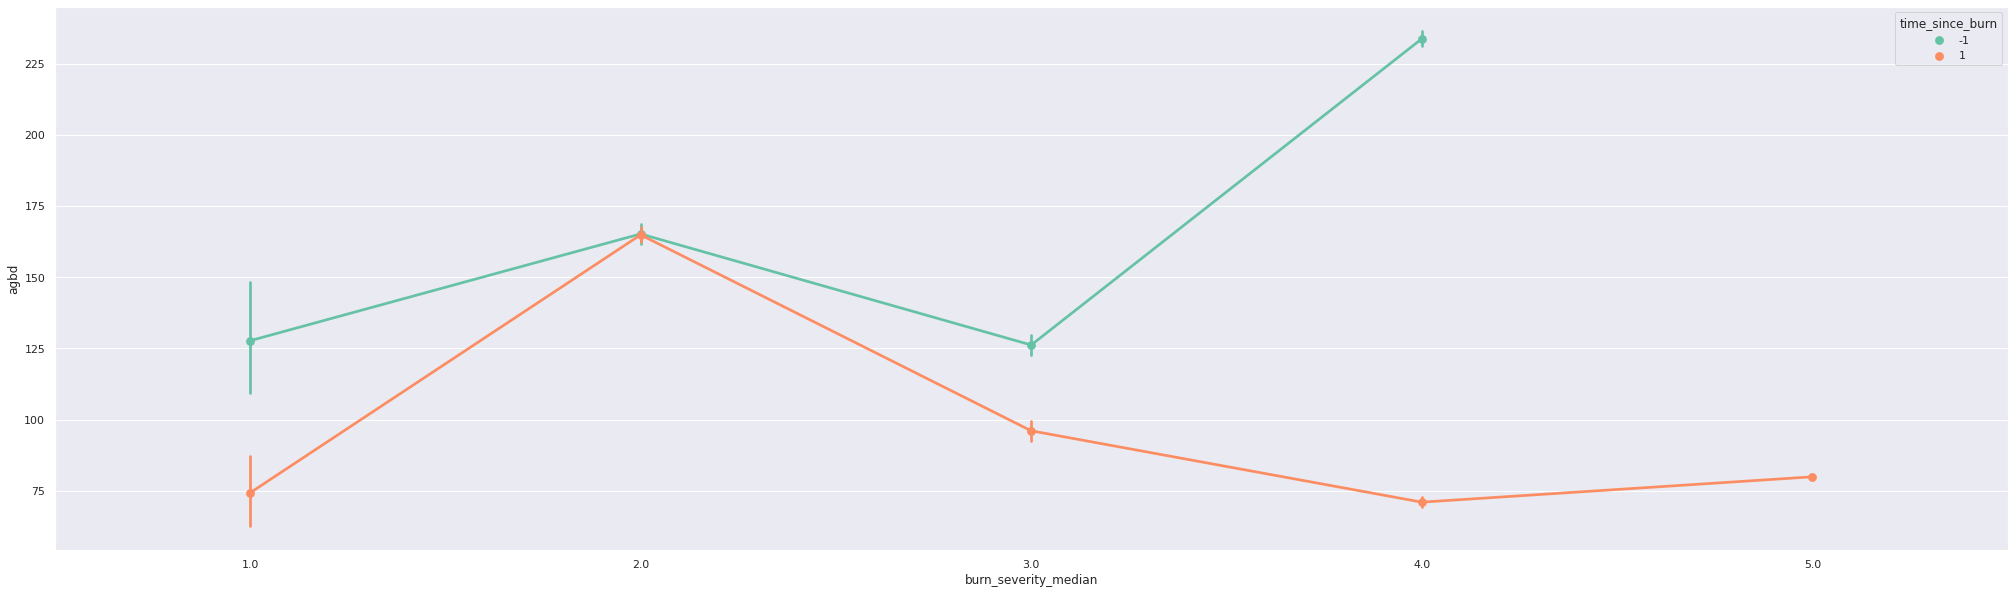

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_recent_perfect[gedi_recent_perfect.pft_class==1], x='burn_severity_median', y='agbd', hue='time_since_burn', palette='Set2')

<AxesSubplot: xlabel='burn_severity_median', ylabel='agbd'>

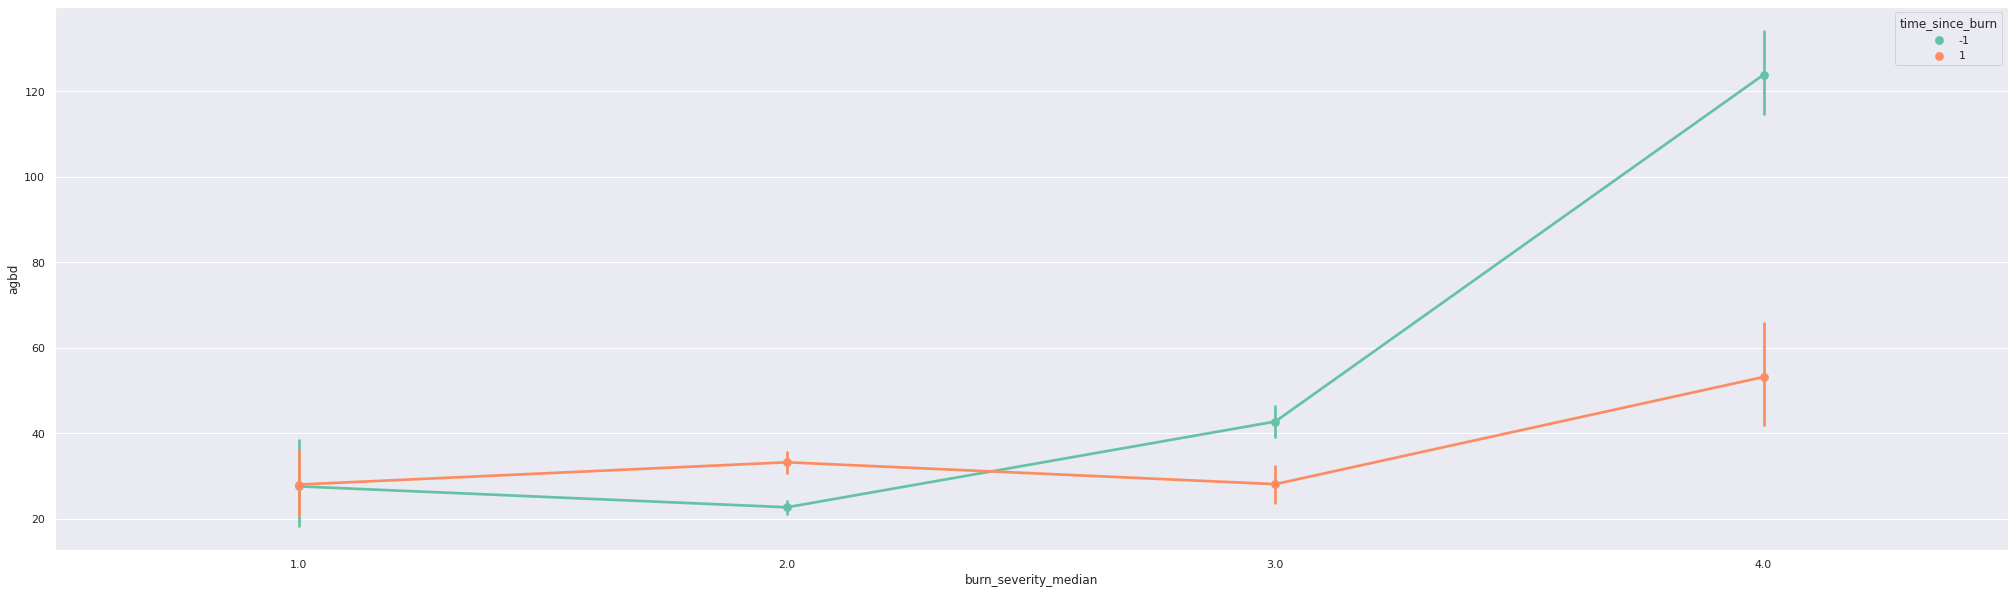

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_recent_perfect[gedi_recent_perfect.pft_class==6], x='burn_severity_median', y='agbd', hue='time_since_burn', palette='Set2')

<AxesSubplot: xlabel='burn_severity_median', ylabel='agbd'>

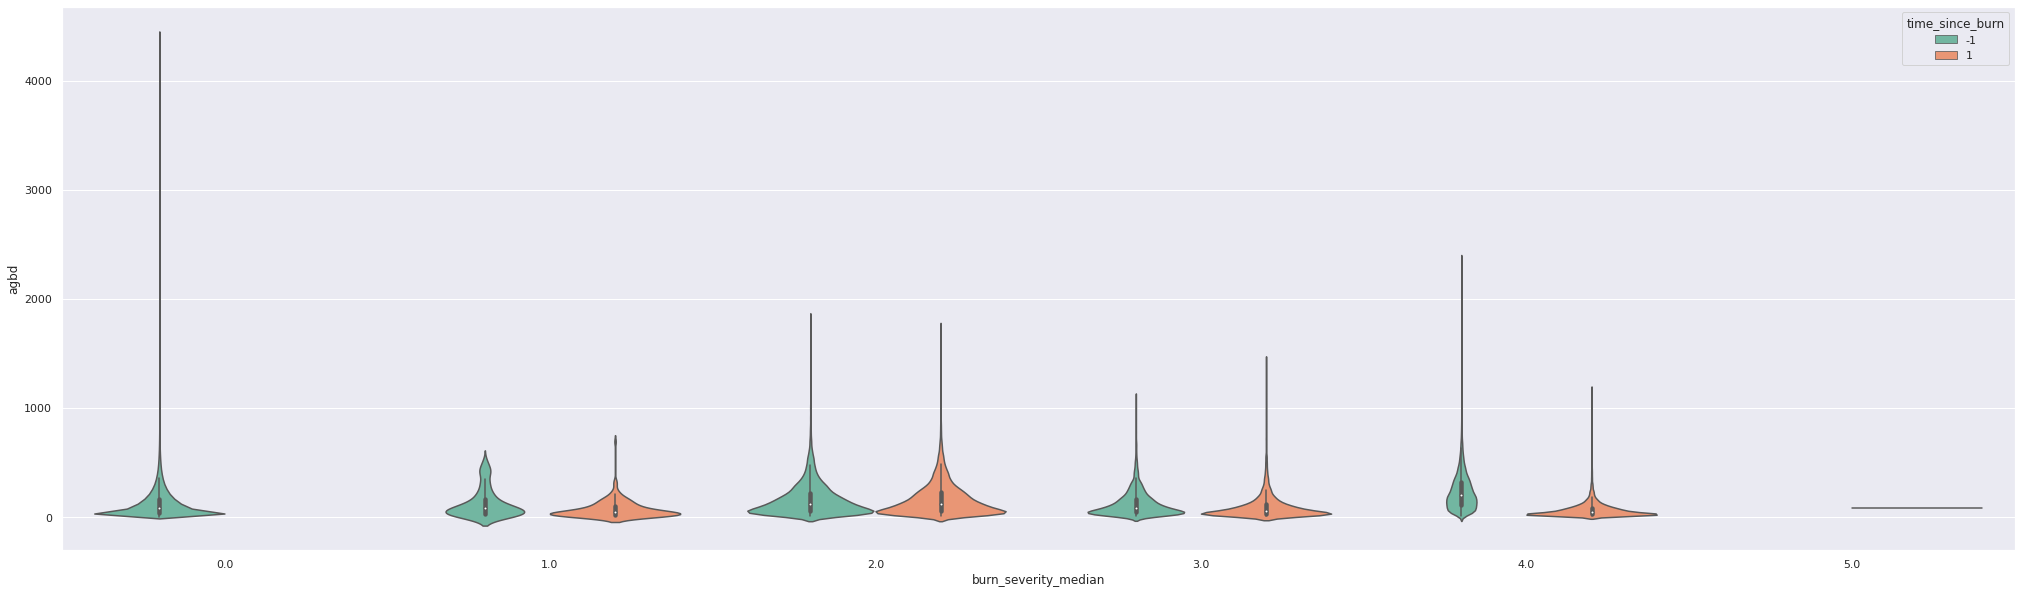

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.violinplot(gedi_all, x='burn_severity_median', y='agbd', hue='time_since_burn', palette='Set2')

<AxesSubplot: xlabel='burn_severity_median', ylabel='agbd'>

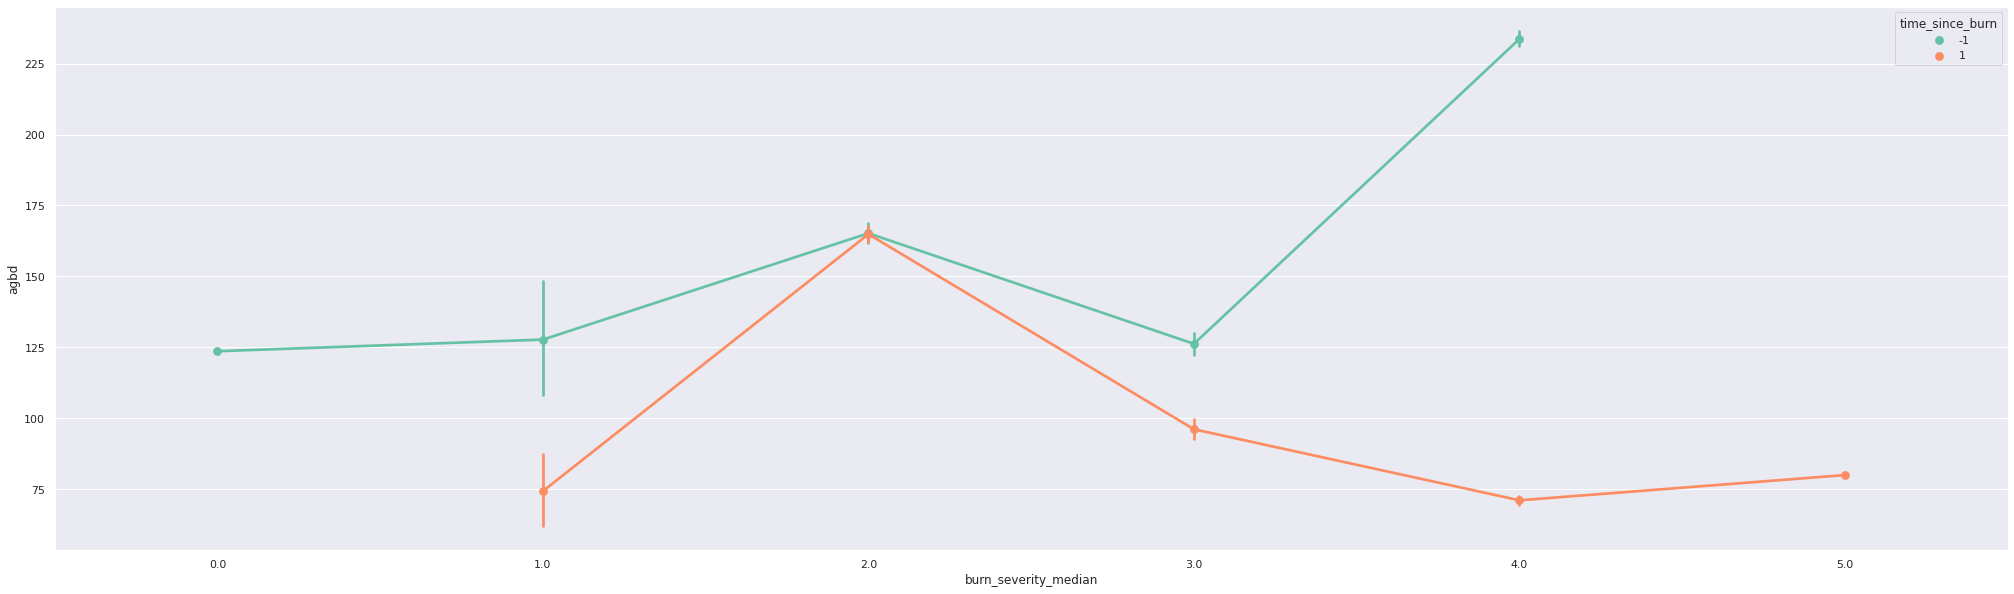

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_all, x='burn_severity_median', y='agbd', hue='time_since_burn', palette='Set2')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.boxplot(gedi_recent_imperfect[gedi_recent_imperfect.pft_class==1], x='burn_severity_median', y='agbd', hue='time_since_burn', palette='Set2')

### Data filtering - based on burn severity

In [14]:
gedi_burn_imperfect_match.pft_class.unique()

array([ 6,  1, 11,  5,  8,  9,  4,  2,  7, 10])

<AxesSubplot: xlabel='pft_class', ylabel='Count'>

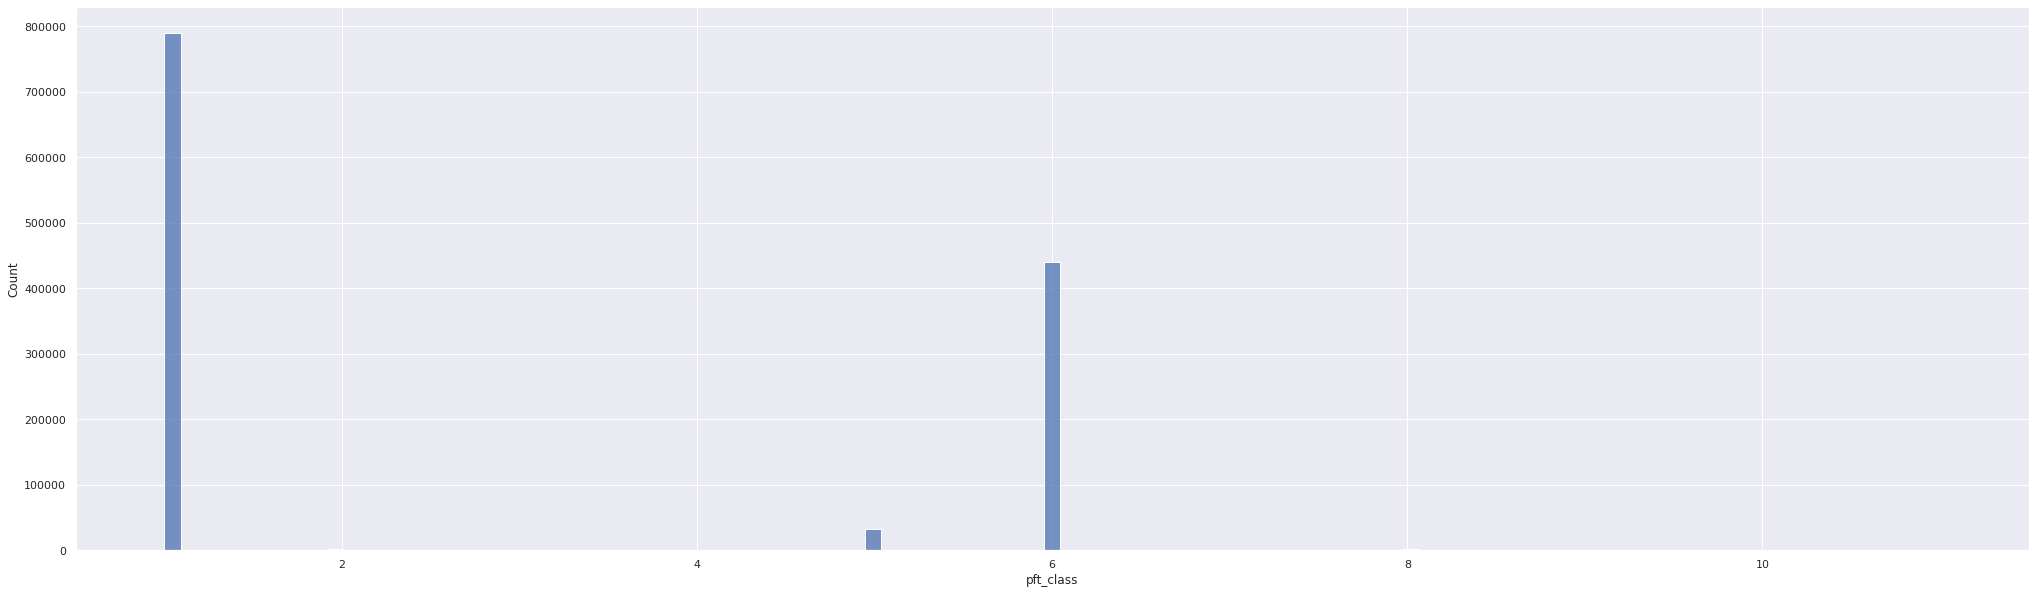

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.histplot(gedi_burn_imperfect_match, x='pft_class')

In [16]:
gedi_burn_imperfect_match[gedi_burn_imperfect_match.pft_class==1].shape[0]

790158

MTBS burn severity values:

* 0 - Background
* 1 - Unburned to Low
* 2 - Low
* 3 - Moderate
* 4 - High
* 5 - Increased Greenness
* 6 - Non-Mapping Area

In [17]:
# Let's focus on burn categories 1, 2, 3, 4
gedi_burn_perfect_match = gedi_burn_perfect_match[gedi_burn_perfect_match.burn_severity_median.isin([1, 2, 3, 4])]
gedi_burn_imperfect_match = gedi_burn_imperfect_match[gedi_burn_imperfect_match.burn_severity_median.isin([1, 2, 3, 4])]
print(gedi_burn_imperfect_match.shape[0])
print(gedi_burn_perfect_match.shape[0])

1264259
384557


In [18]:
gedi_burn_perfect_match = gedi_burn_perfect_match[gedi_burn_perfect_match.pft_class == 1]
gedi_burn_imperfect_match = gedi_burn_imperfect_match[gedi_burn_imperfect_match.pft_class == 1]
print(gedi_burn_imperfect_match.shape[0])
print(gedi_burn_perfect_match.shape[0])

789088
198144


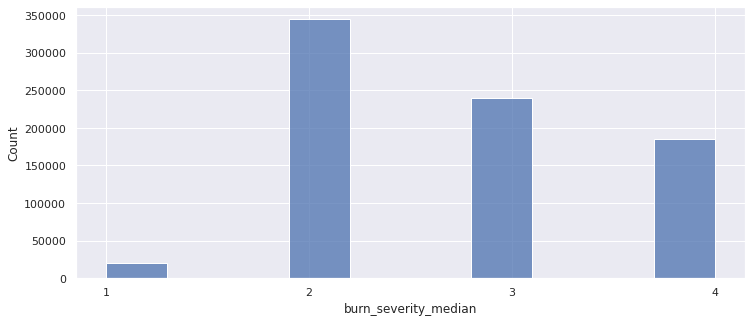

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
g = sns.histplot(gedi_burn_imperfect_match, x='burn_severity_median', bins=10)
g.set_xticks(range(1, 5))

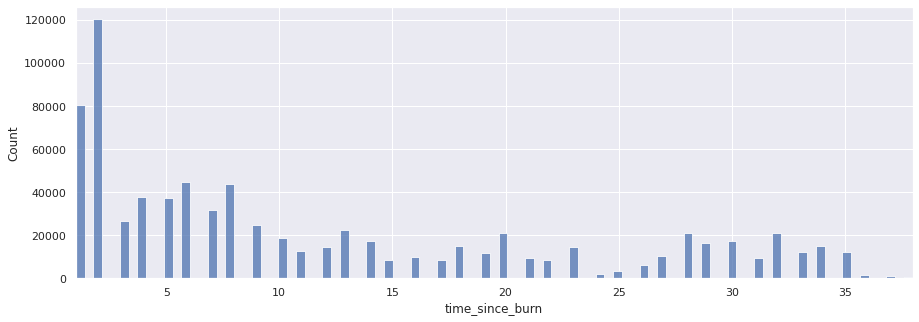

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
g = sns.histplot(gedi_burn_imperfect_match, x='time_since_burn')
ax.margins(x=0)
#g.set_xticks(range(1, 5))

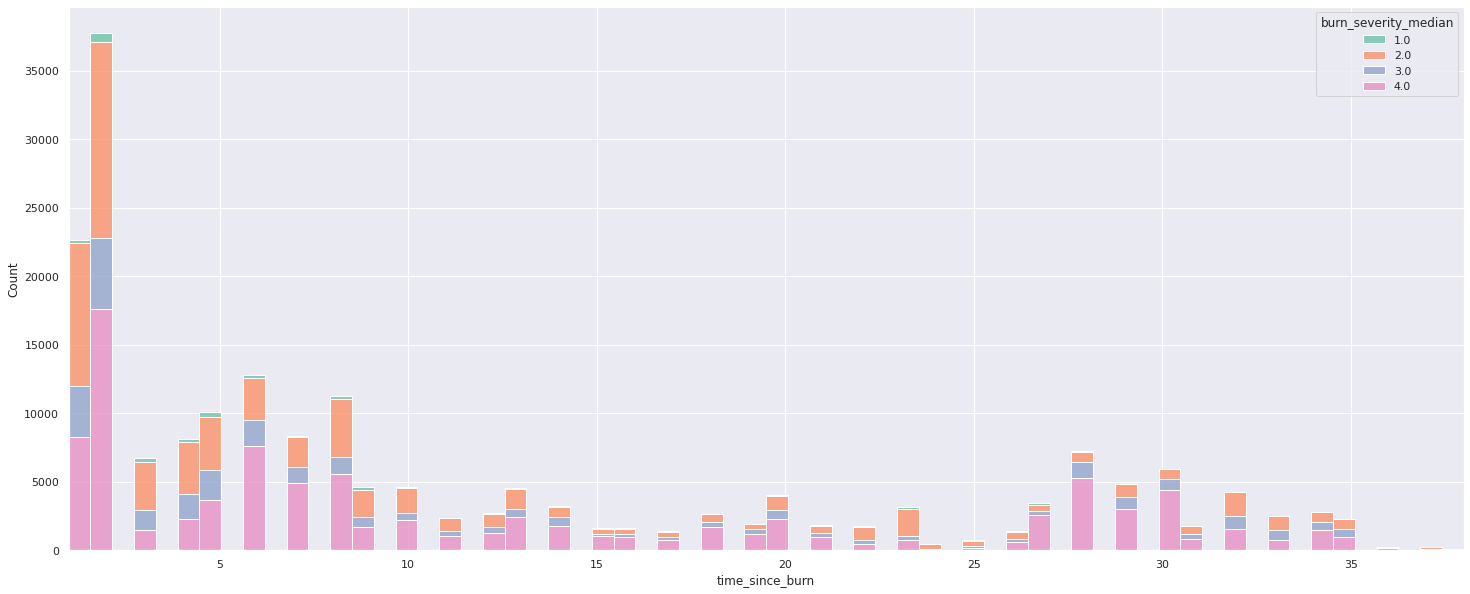

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.histplot(gedi_burn_perfect_match, x='time_since_burn', hue='burn_severity_median', palette='Set2', multiple="stack")
ax.margins(x=0)

<AxesSubplot: xlabel='time_since_burn', ylabel='Count'>

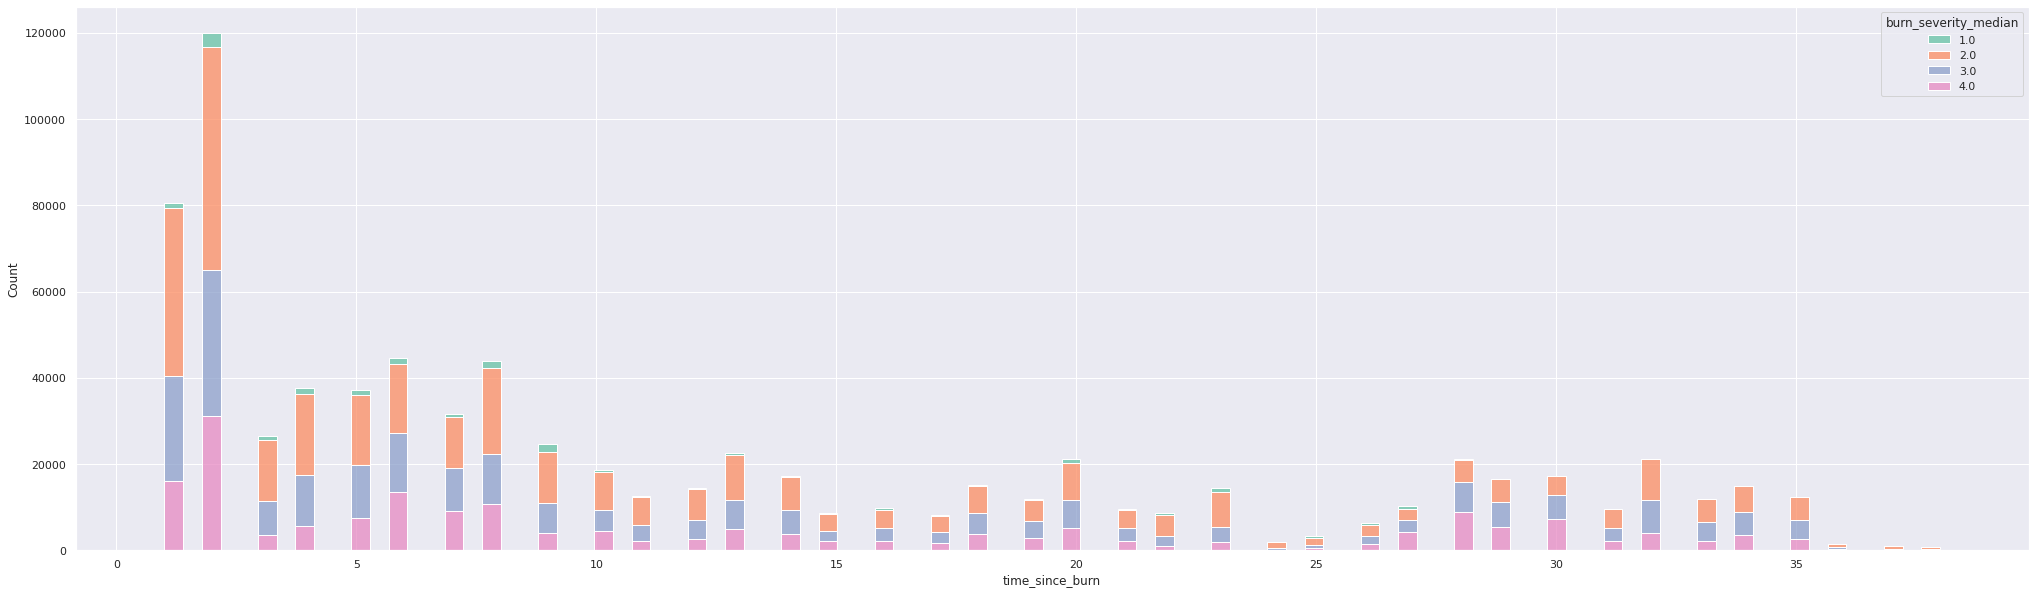

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.histplot(gedi_burn_imperfect_match, x='time_since_burn', hue='burn_severity_median', palette='Set2', multiple="stack")

<AxesSubplot: xlabel='time_since_burn', ylabel='agbd'>

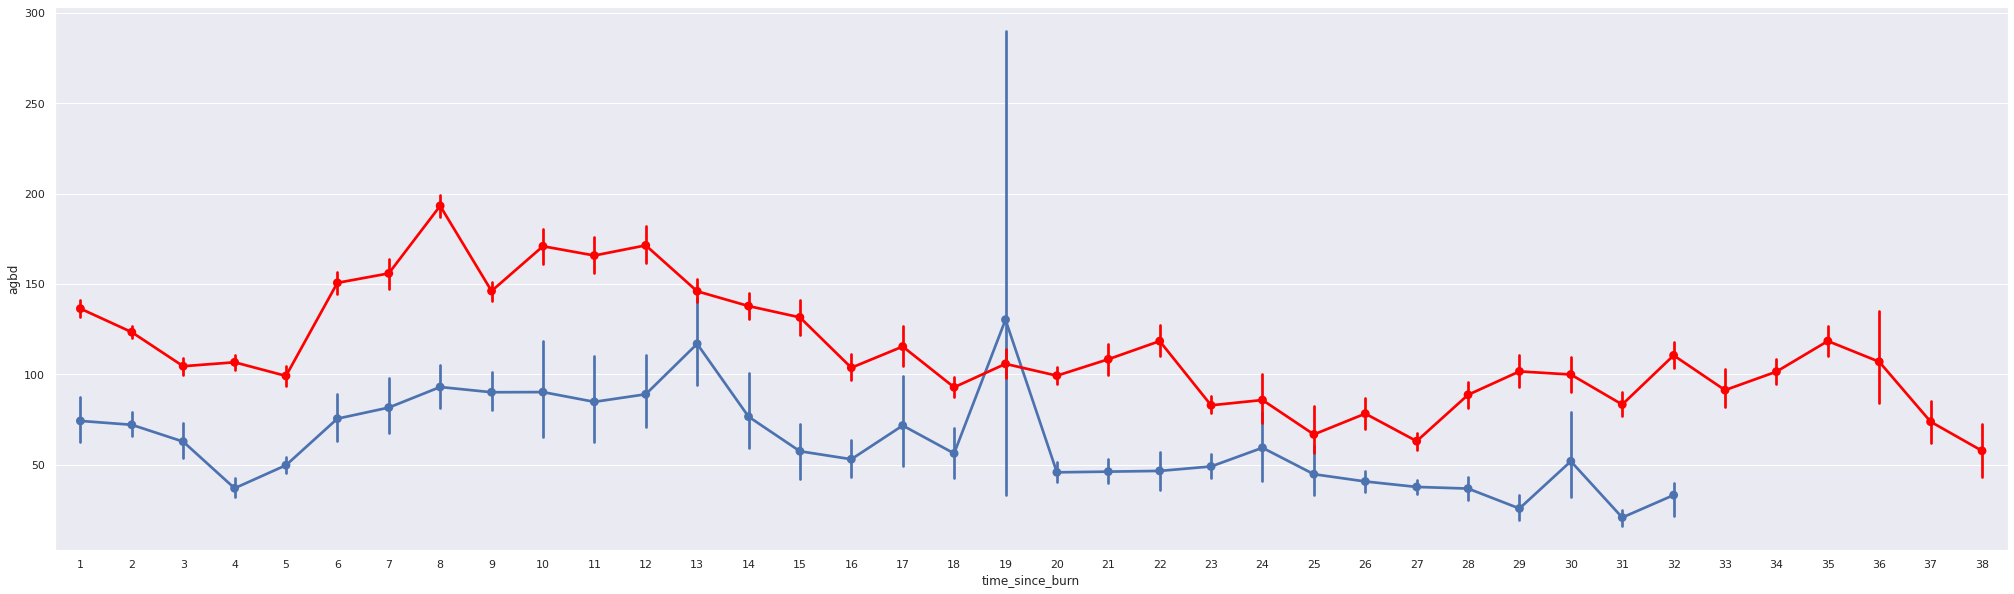

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_burn_perfect_match[gedi_burn_perfect_match.burn_severity_sample == 1], x='time_since_burn', y='agbd')
sns.pointplot(gedi_burn_imperfect_match[gedi_burn_imperfect_match.burn_severity_sample == 1], x='time_since_burn', y='agbd', color='red')

<AxesSubplot: xlabel='time_since_burn', ylabel='agbd'>

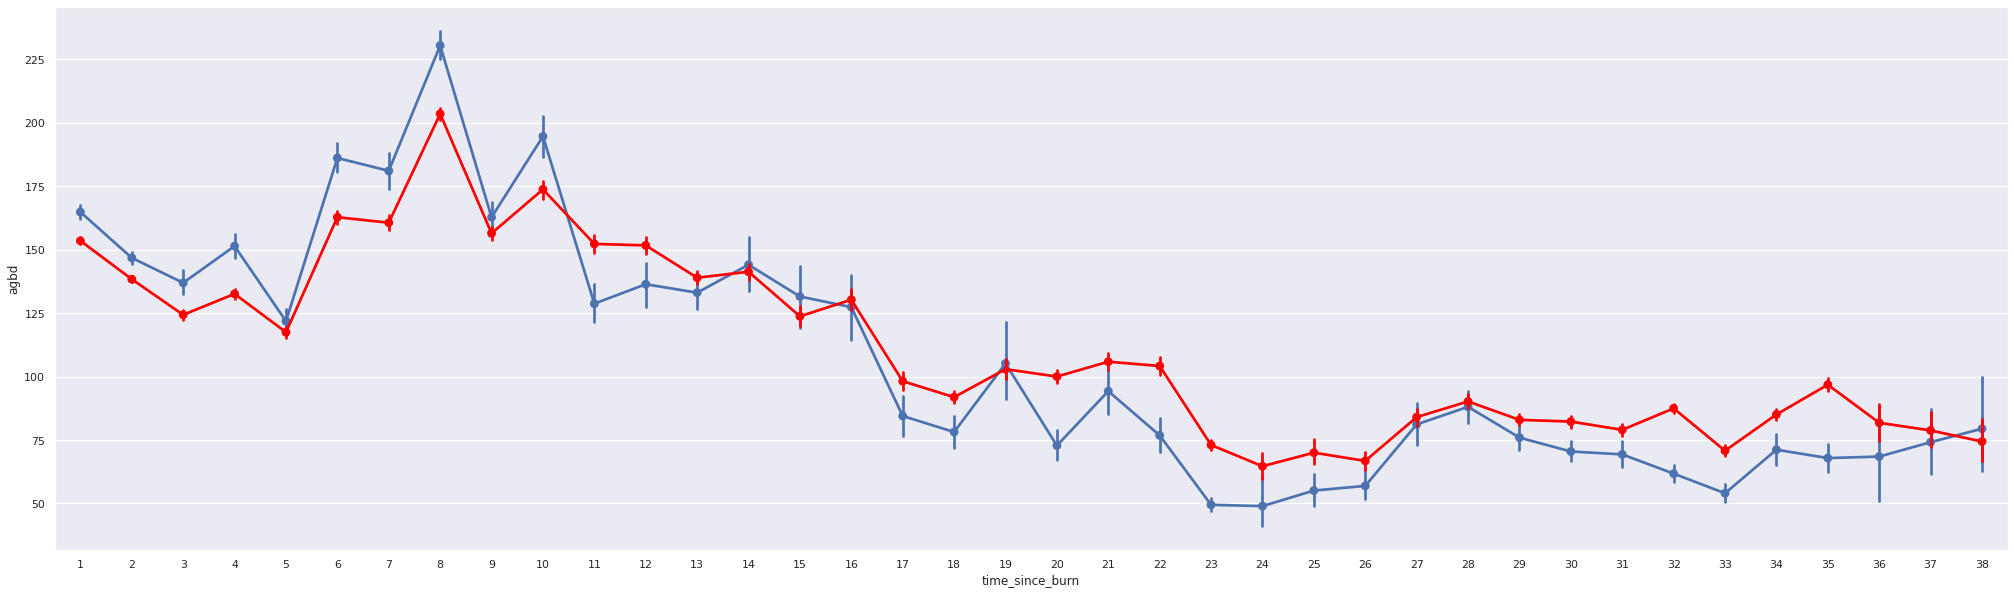

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_burn_perfect_match[gedi_burn_perfect_match.burn_severity_sample == 2], x='time_since_burn', y='agbd')
sns.pointplot(gedi_burn_imperfect_match[gedi_burn_imperfect_match.burn_severity_sample == 2], x='time_since_burn', y='agbd', color='red')

<AxesSubplot: xlabel='time_since_burn', ylabel='agbd'>

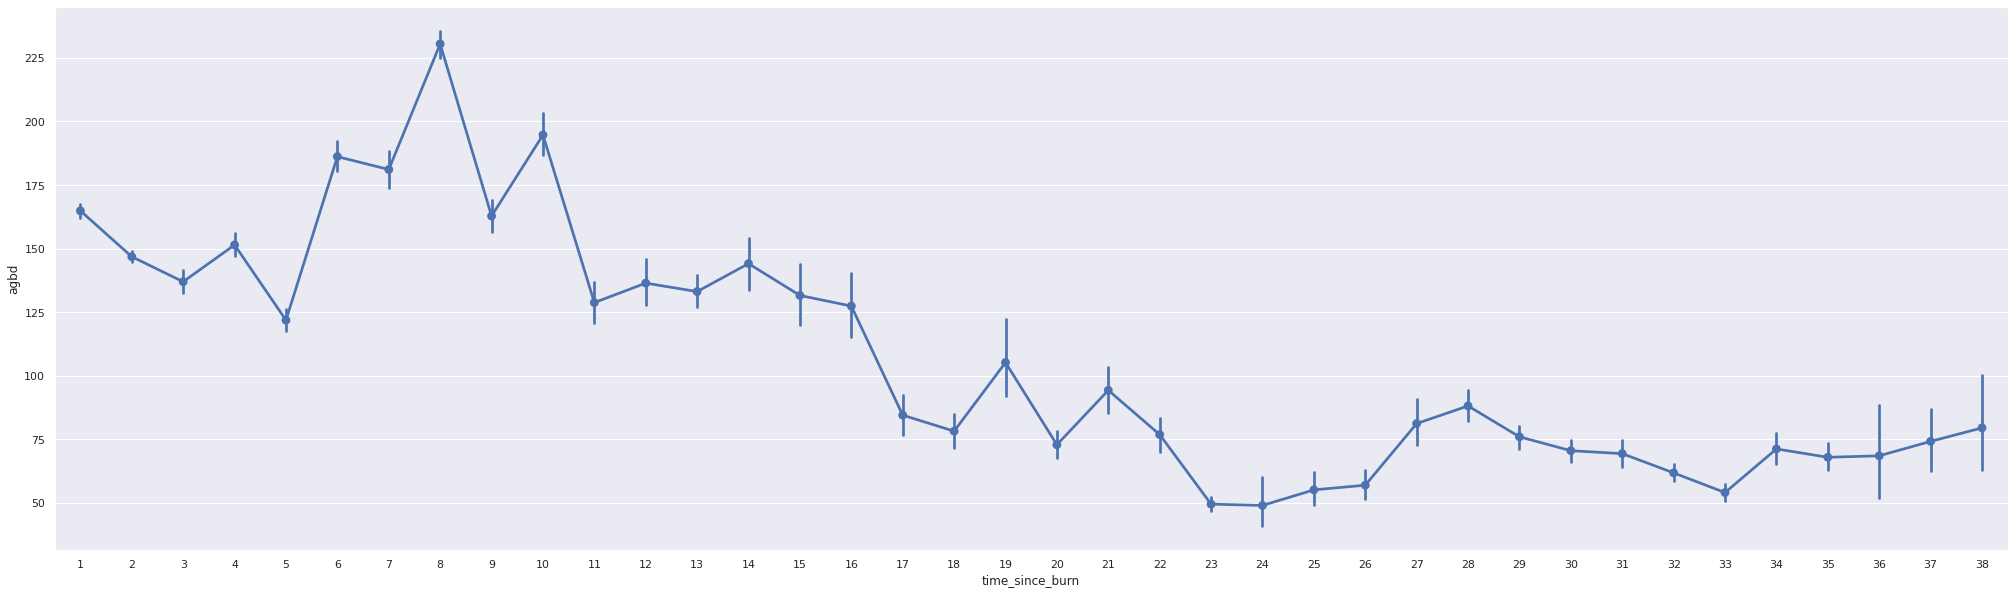

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_burn_perfect_match[gedi_burn_perfect_match.burn_severity_sample == 2], x='time_since_burn', y='agbd')

<AxesSubplot: xlabel='time_since_burn', ylabel='agbd'>

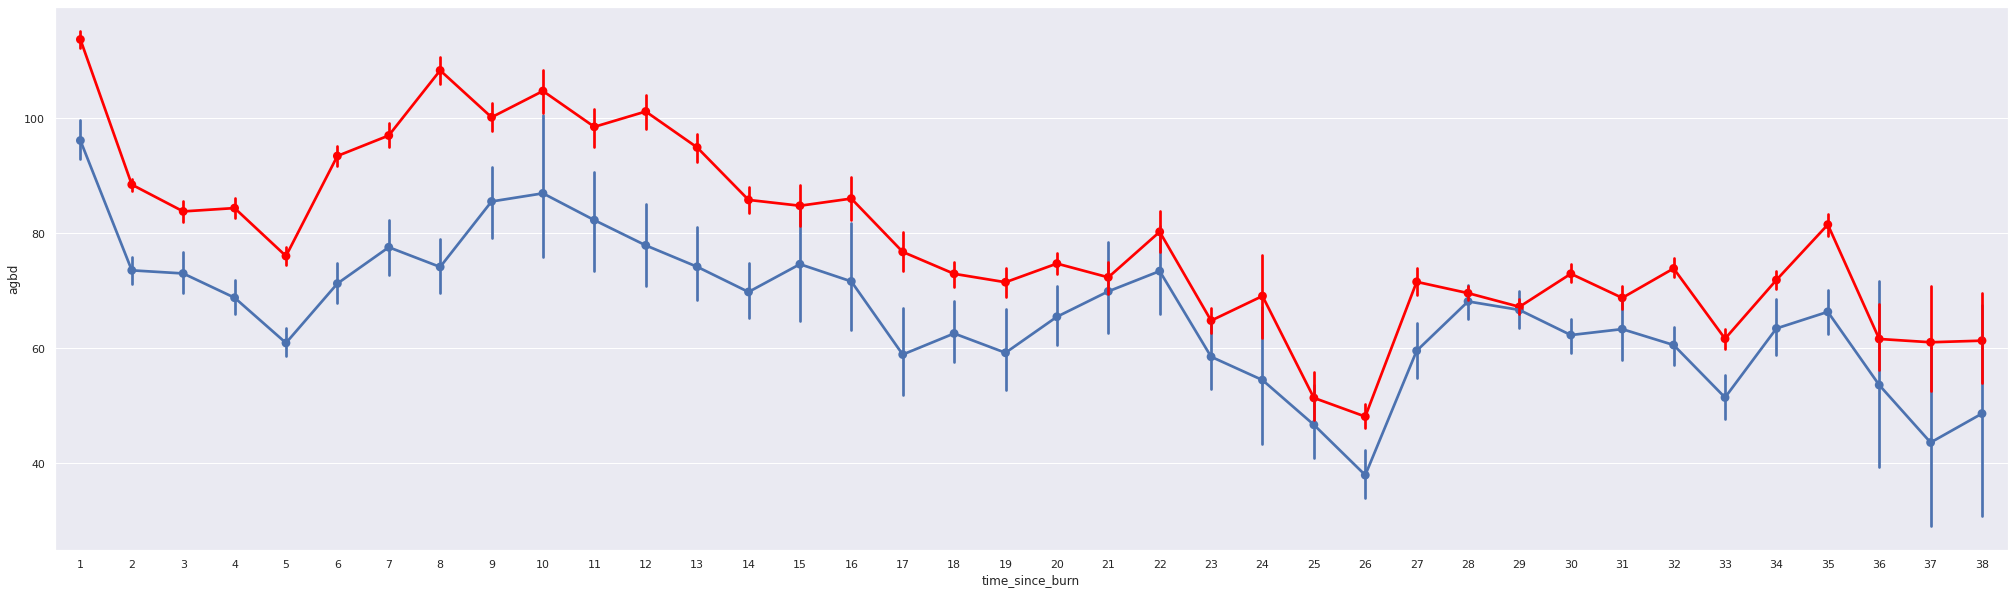

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_burn_perfect_match[gedi_burn_perfect_match.burn_severity_sample == 3], x='time_since_burn', y='agbd')
sns.pointplot(gedi_burn_imperfect_match[gedi_burn_imperfect_match.burn_severity_sample == 3], x='time_since_burn', y='agbd', color='red')

<AxesSubplot: xlabel='time_since_burn', ylabel='agbd'>

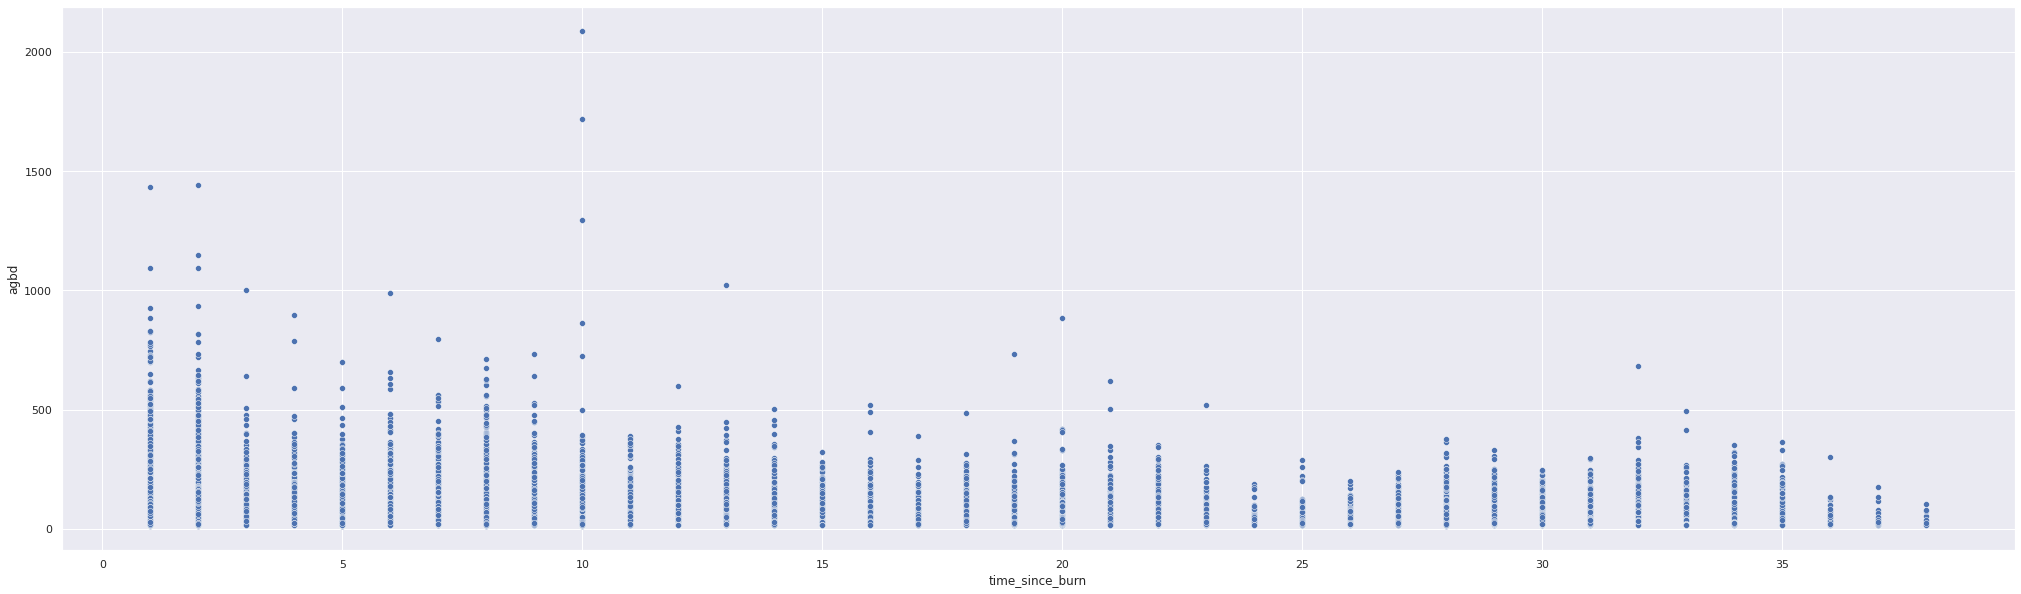

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.scatterplot(gedi_burn_perfect_match[gedi_burn_perfect_match.burn_severity_sample == 3], x='time_since_burn', y='agbd')

<AxesSubplot: xlabel='time_since_burn', ylabel='agbd'>

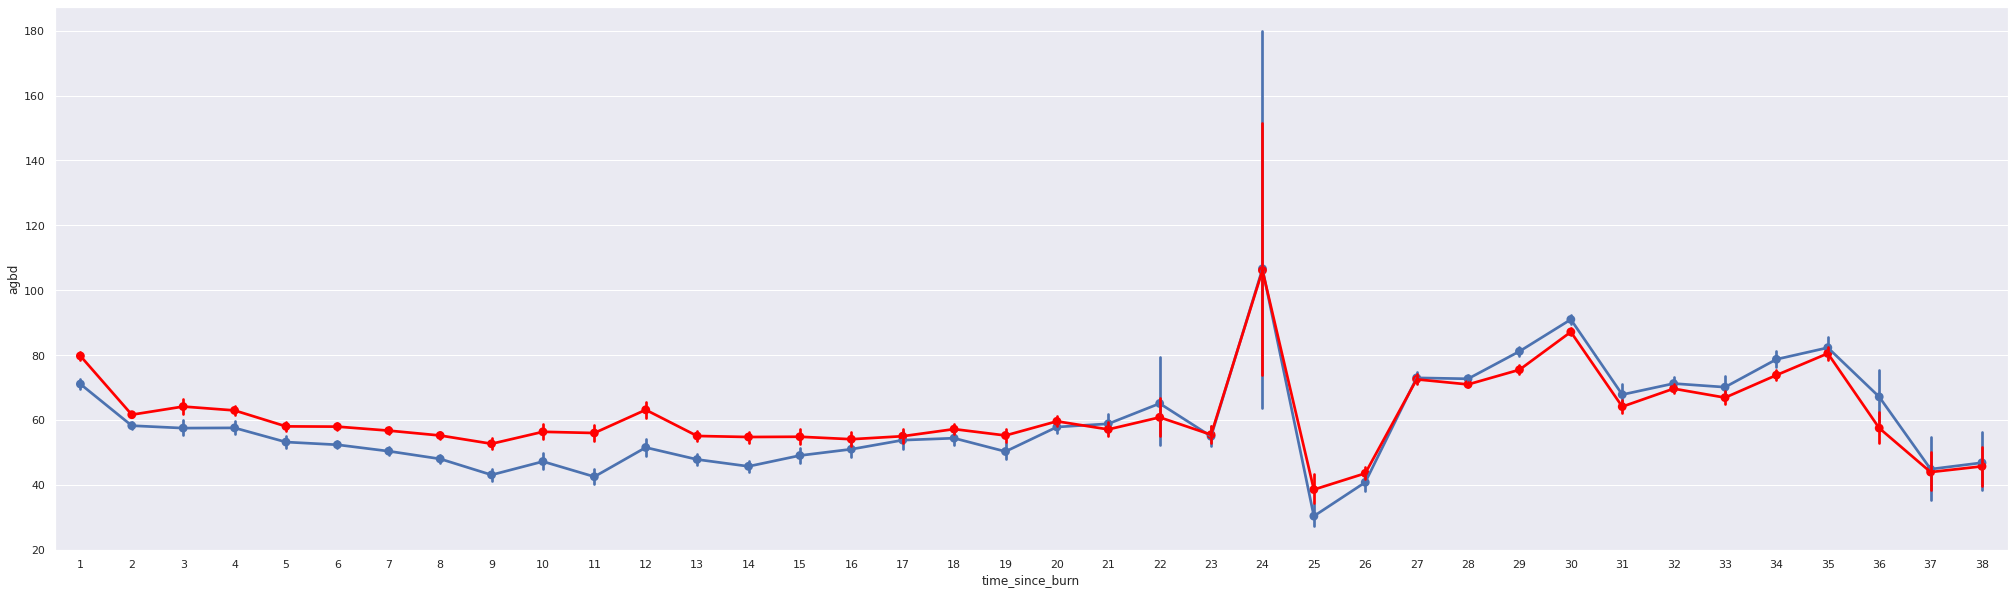

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_burn_perfect_match[gedi_burn_perfect_match.burn_severity_sample == 4], x='time_since_burn', y='agbd')
sns.pointplot(gedi_burn_imperfect_match[gedi_burn_imperfect_match.burn_severity_sample == 4], x='time_since_burn', y='agbd', color='red')

<AxesSubplot: xlabel='time_since_burn', ylabel='agbd'>

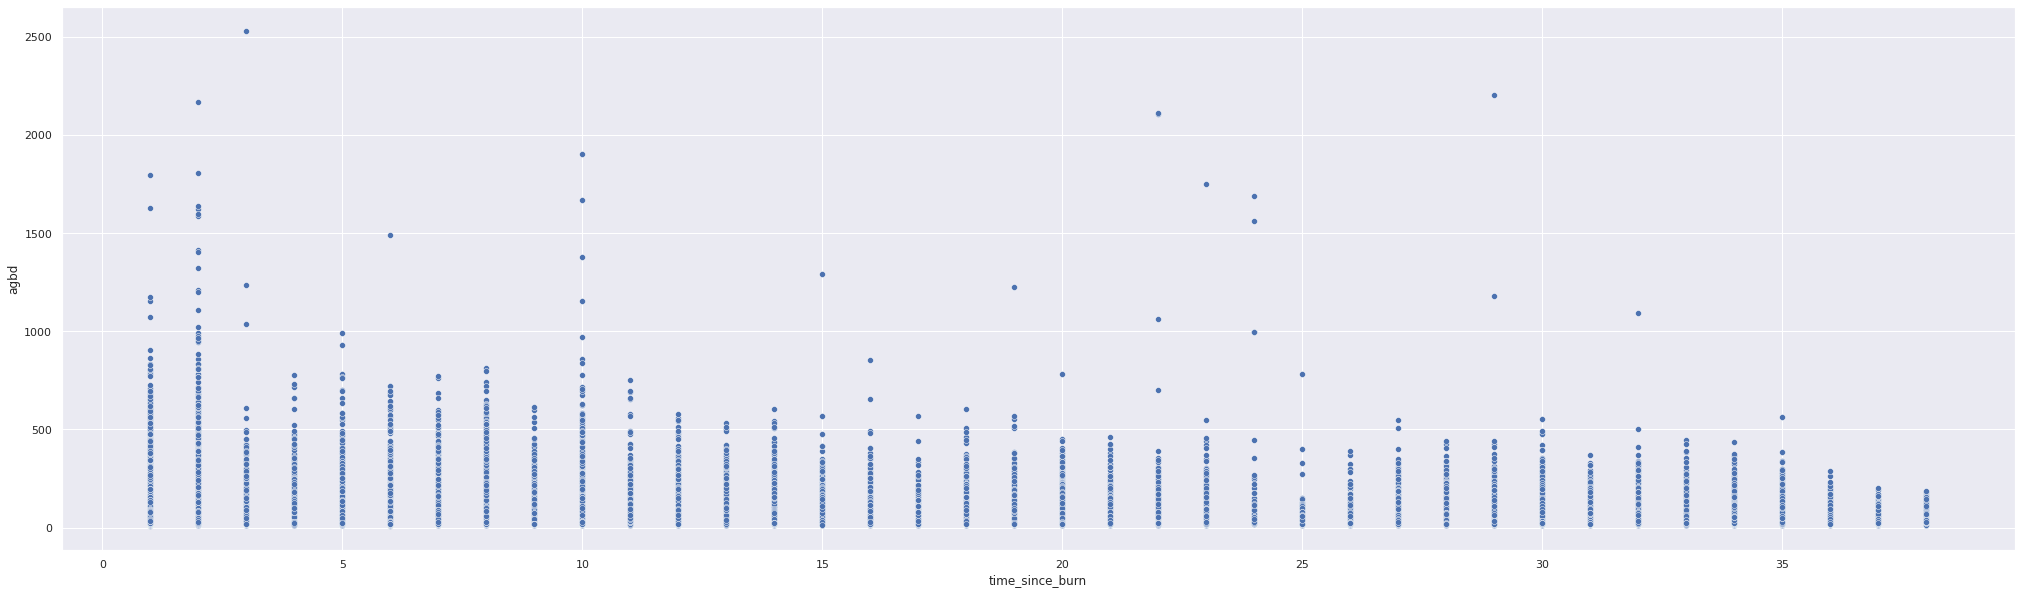

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.scatterplot(gedi_burn_imperfect_match[gedi_burn_imperfect_match.burn_severity_sample == 4], x='time_since_burn', y='agbd')

<AxesSubplot: xlabel='time_since_burn', ylabel='agbd'>

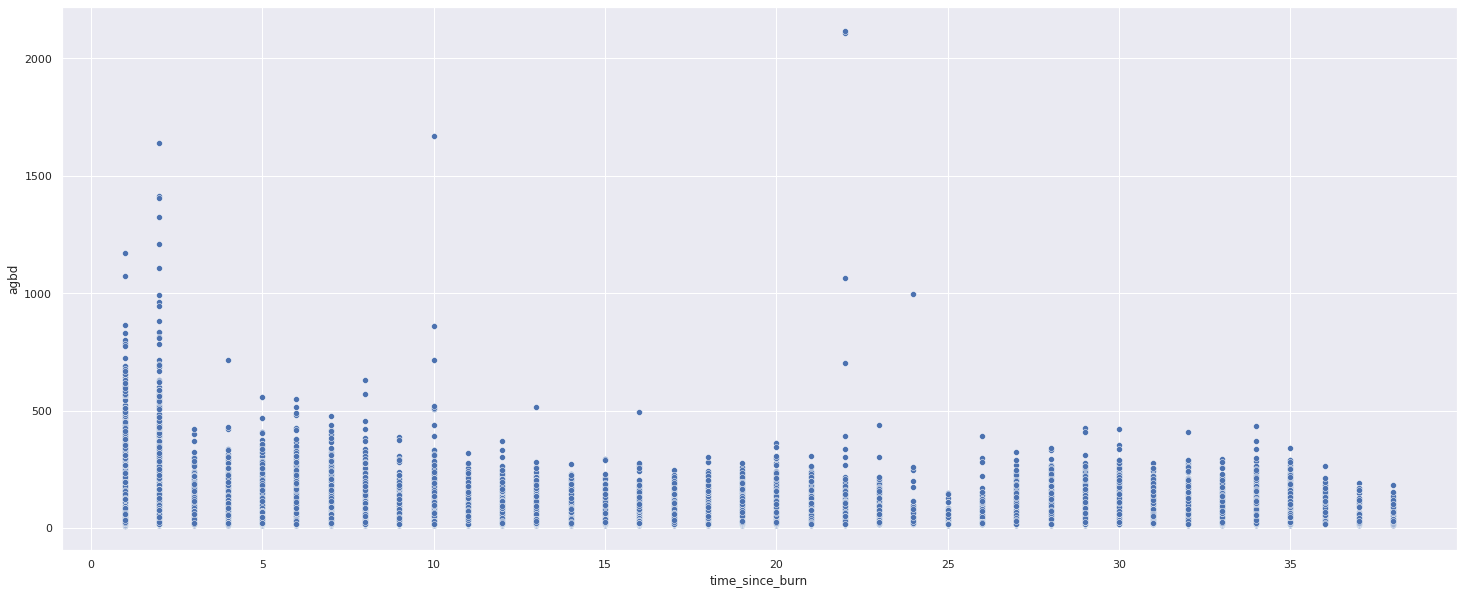

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.scatterplot(gedi_burn_perfect_match[gedi_burn_perfect_match.burn_severity_median == 4], x='time_since_burn', y='agbd')

<AxesSubplot: xlabel='time_since_burn', ylabel='agbd'>

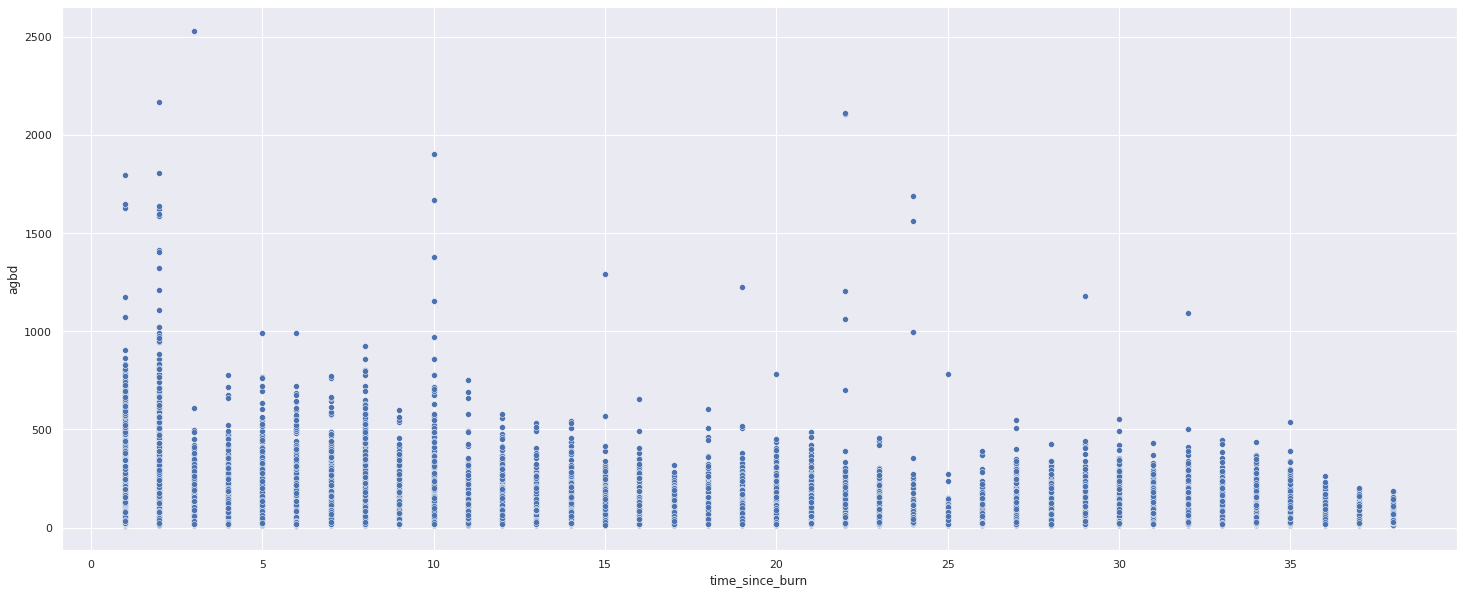

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.scatterplot(gedi_burn_imperfect_match[gedi_burn_imperfect_match.burn_severity_median == 4], x='time_since_burn', y='agbd')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_burn_perfect_match[gedi_burn_perfect_match.burn_severity_sample == 4], x='time_since_burn', y='agbd')
sns.pointplot(gedi_burn_imperfect_match[gedi_burn_imperfect_match.burn_severity_sample == 4], x='time_since_burn', y='agbd', color='red')

<AxesSubplot: xlabel='time_since_burn', ylabel='agbd'>

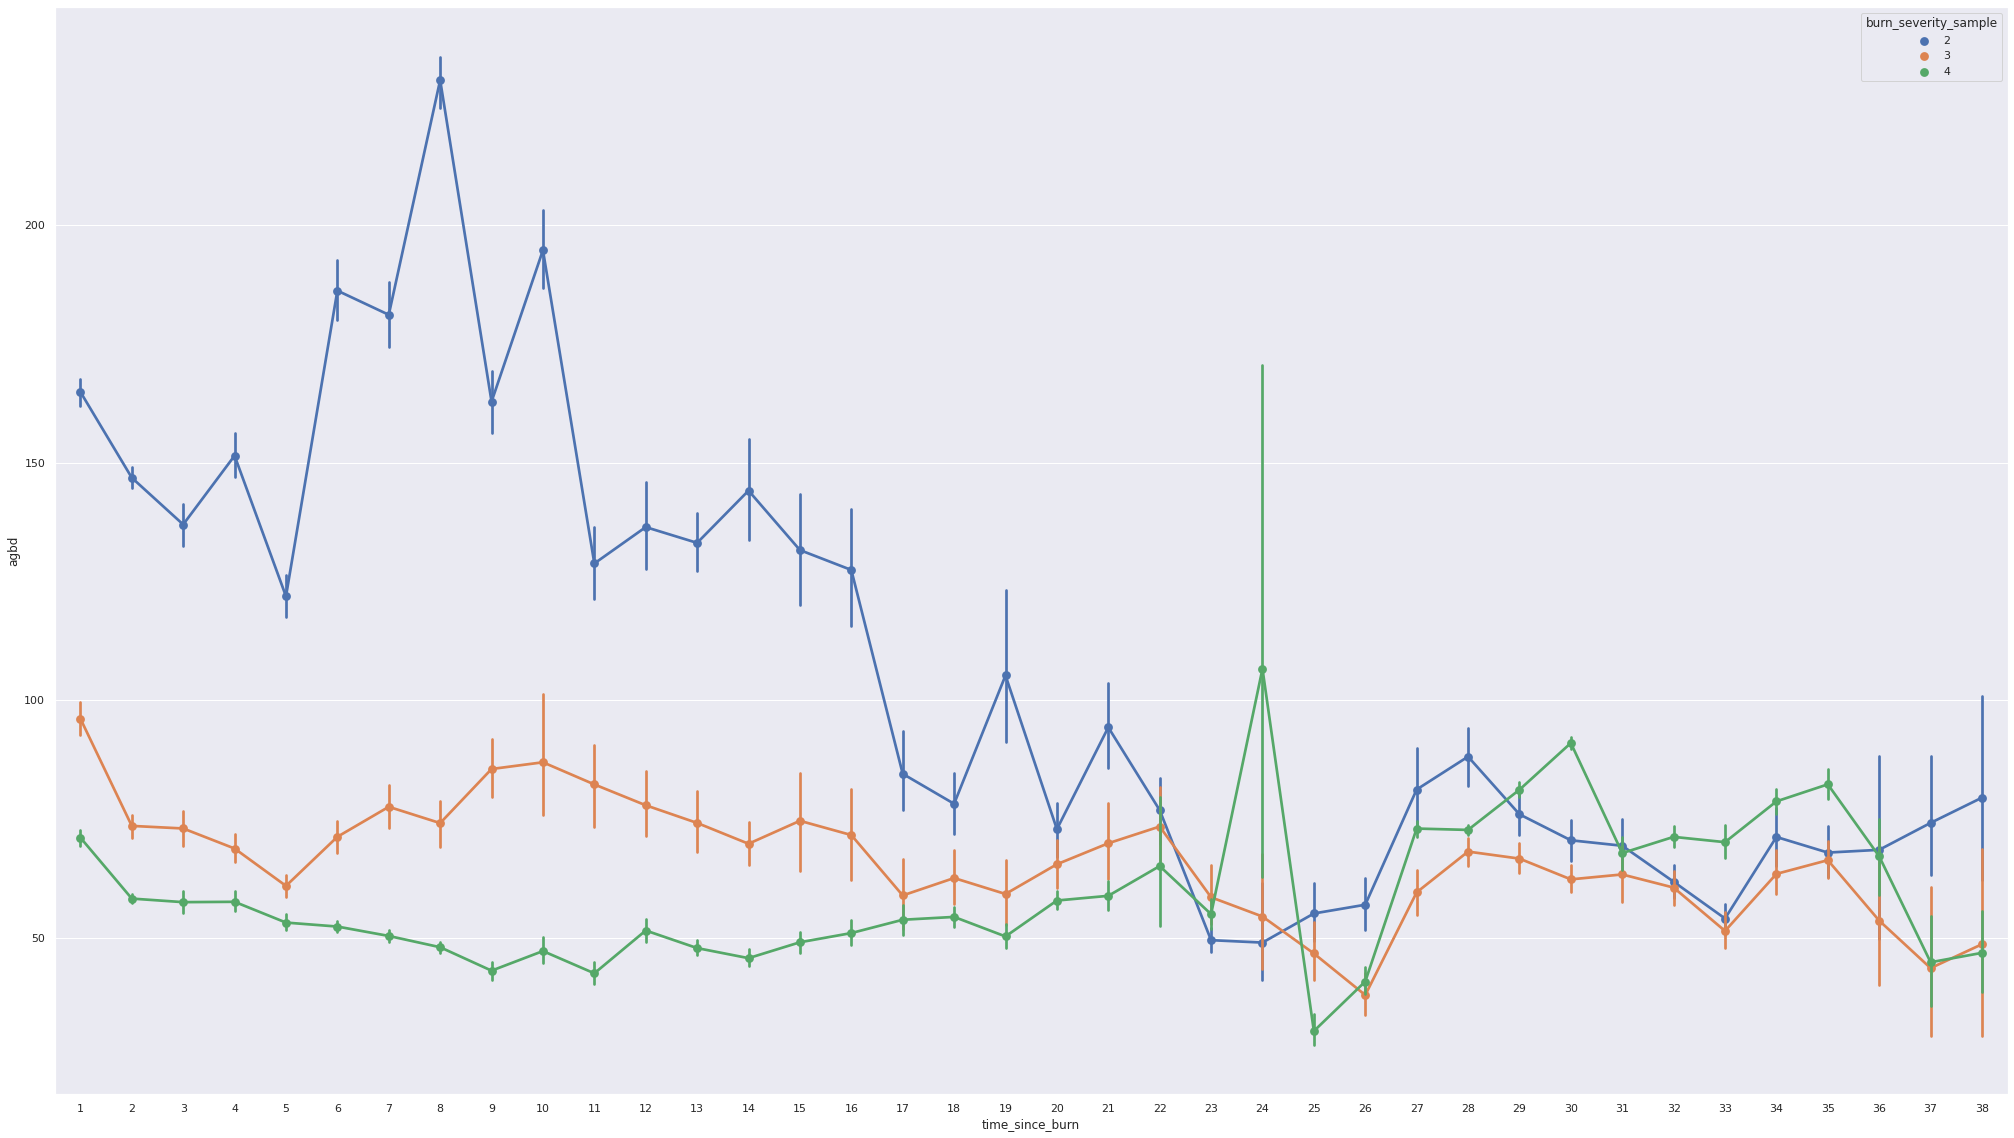

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(35, 20))
sns.pointplot(gedi_burn_perfect_match[gedi_burn_perfect_match.burn_severity_sample.isin([2, 3, 4])], x='time_since_burn', y='agbd', hue='burn_severity_sample')

<AxesSubplot: xlabel='time_since_burn', ylabel='agbd'>

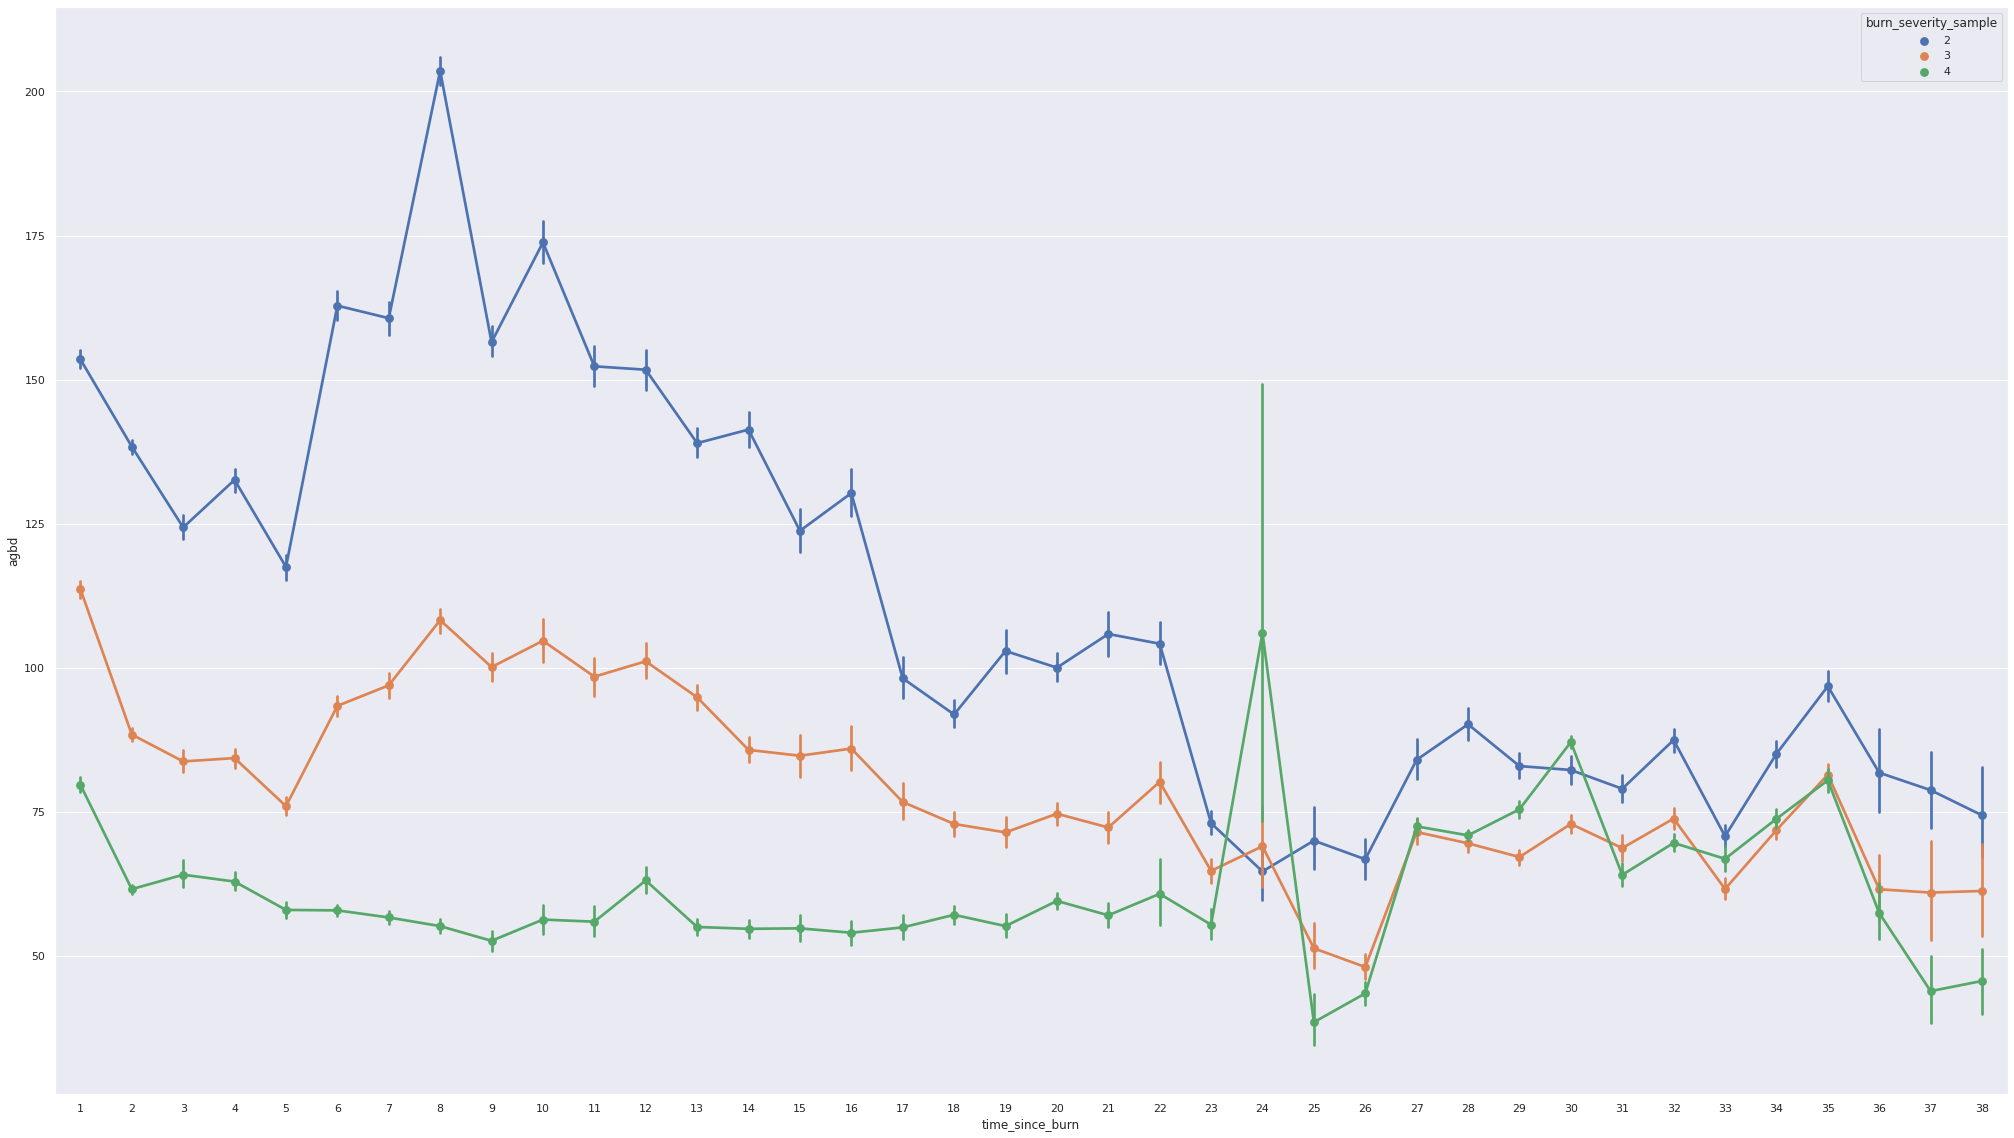

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(35, 20))
sns.pointplot(gedi_burn_imperfect_match[gedi_burn_imperfect_match.burn_severity_sample.isin([2, 3, 4])], x='time_since_burn', y='agbd', hue='burn_severity_sample')

<AxesSubplot: xlabel='time_since_burn', ylabel='agbd'>

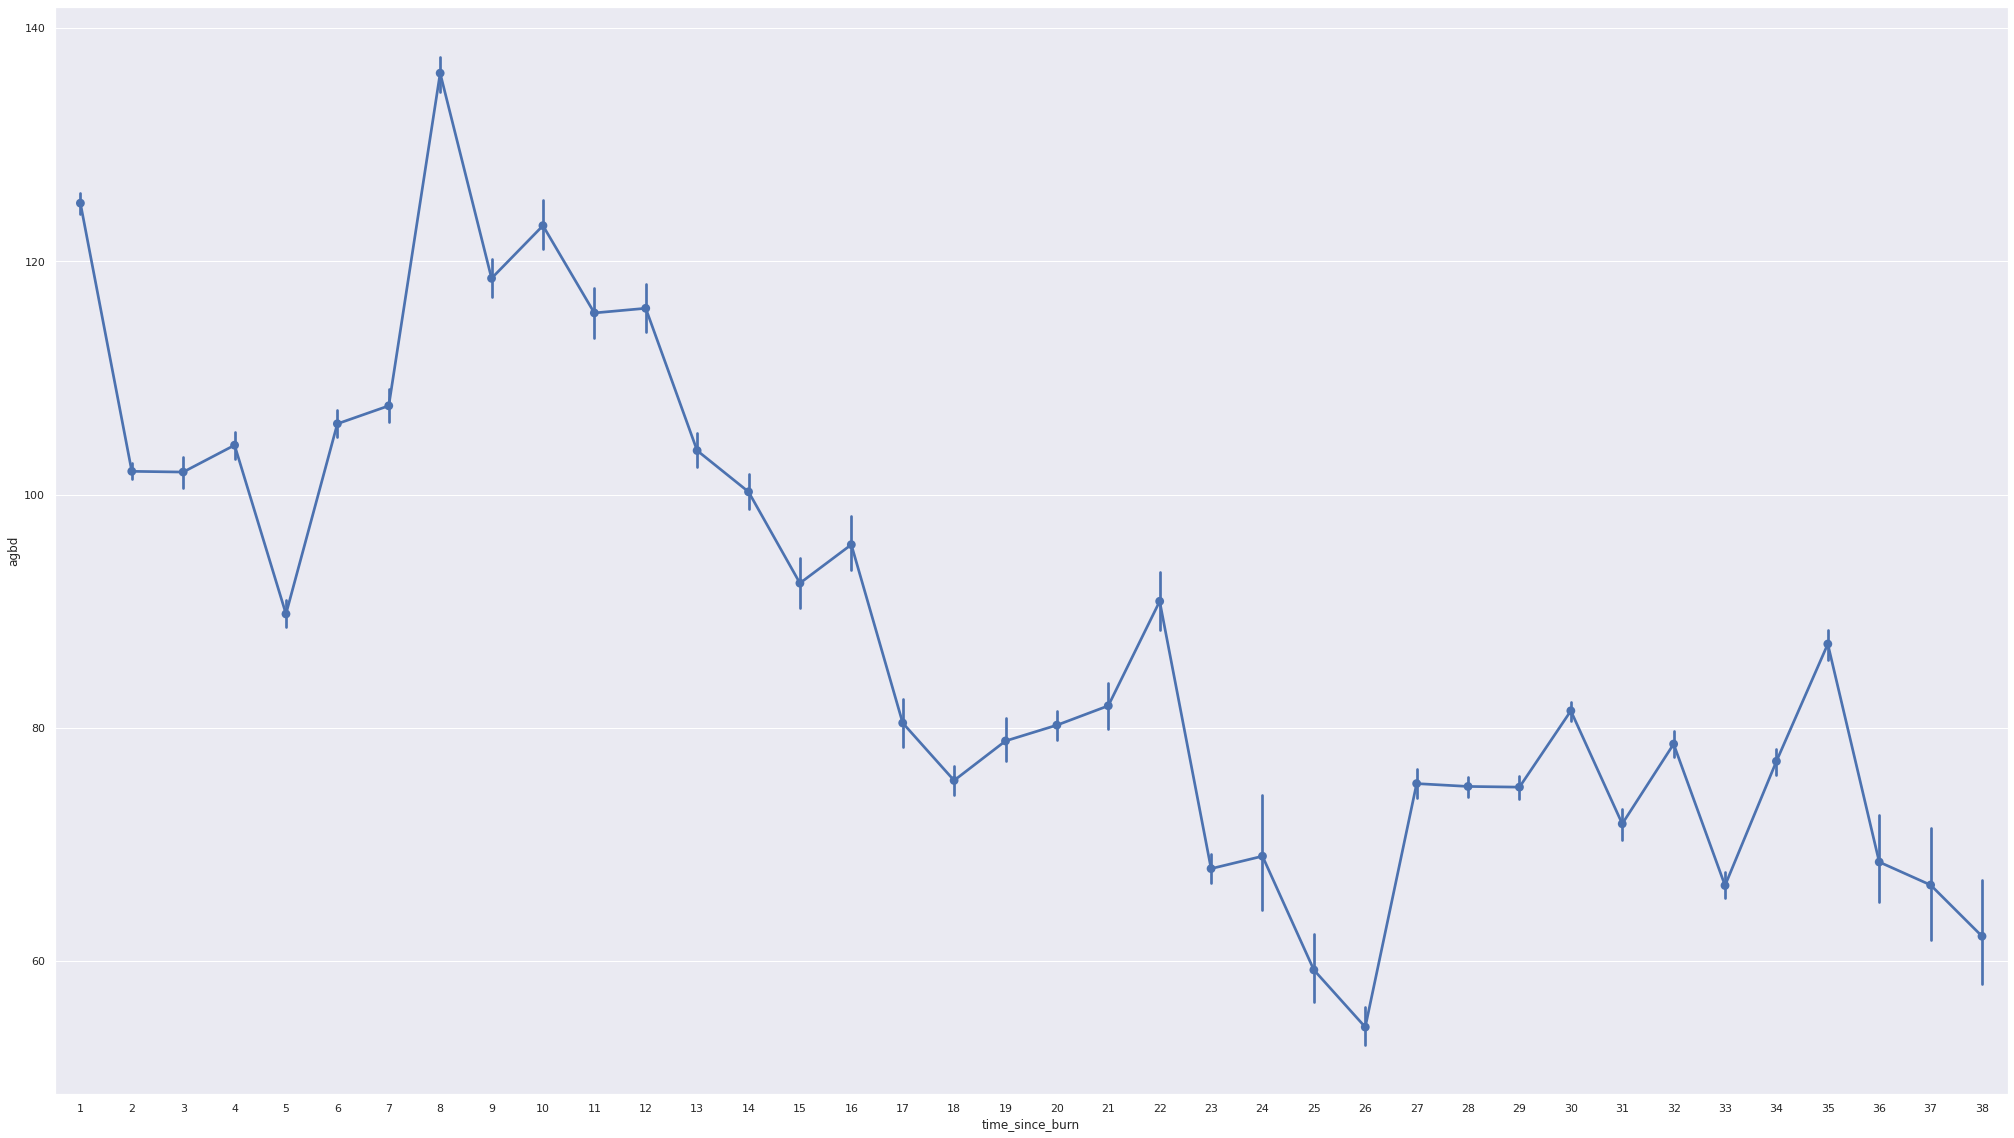

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(35, 20))
sns.pointplot(gedi_burn_imperfect_match[gedi_burn_imperfect_match.burn_severity_sample.isin([2, 3, 4])], x='time_since_burn', y='agbd')

<AxesSubplot: xlabel='time_since_burn', ylabel='agbd'>

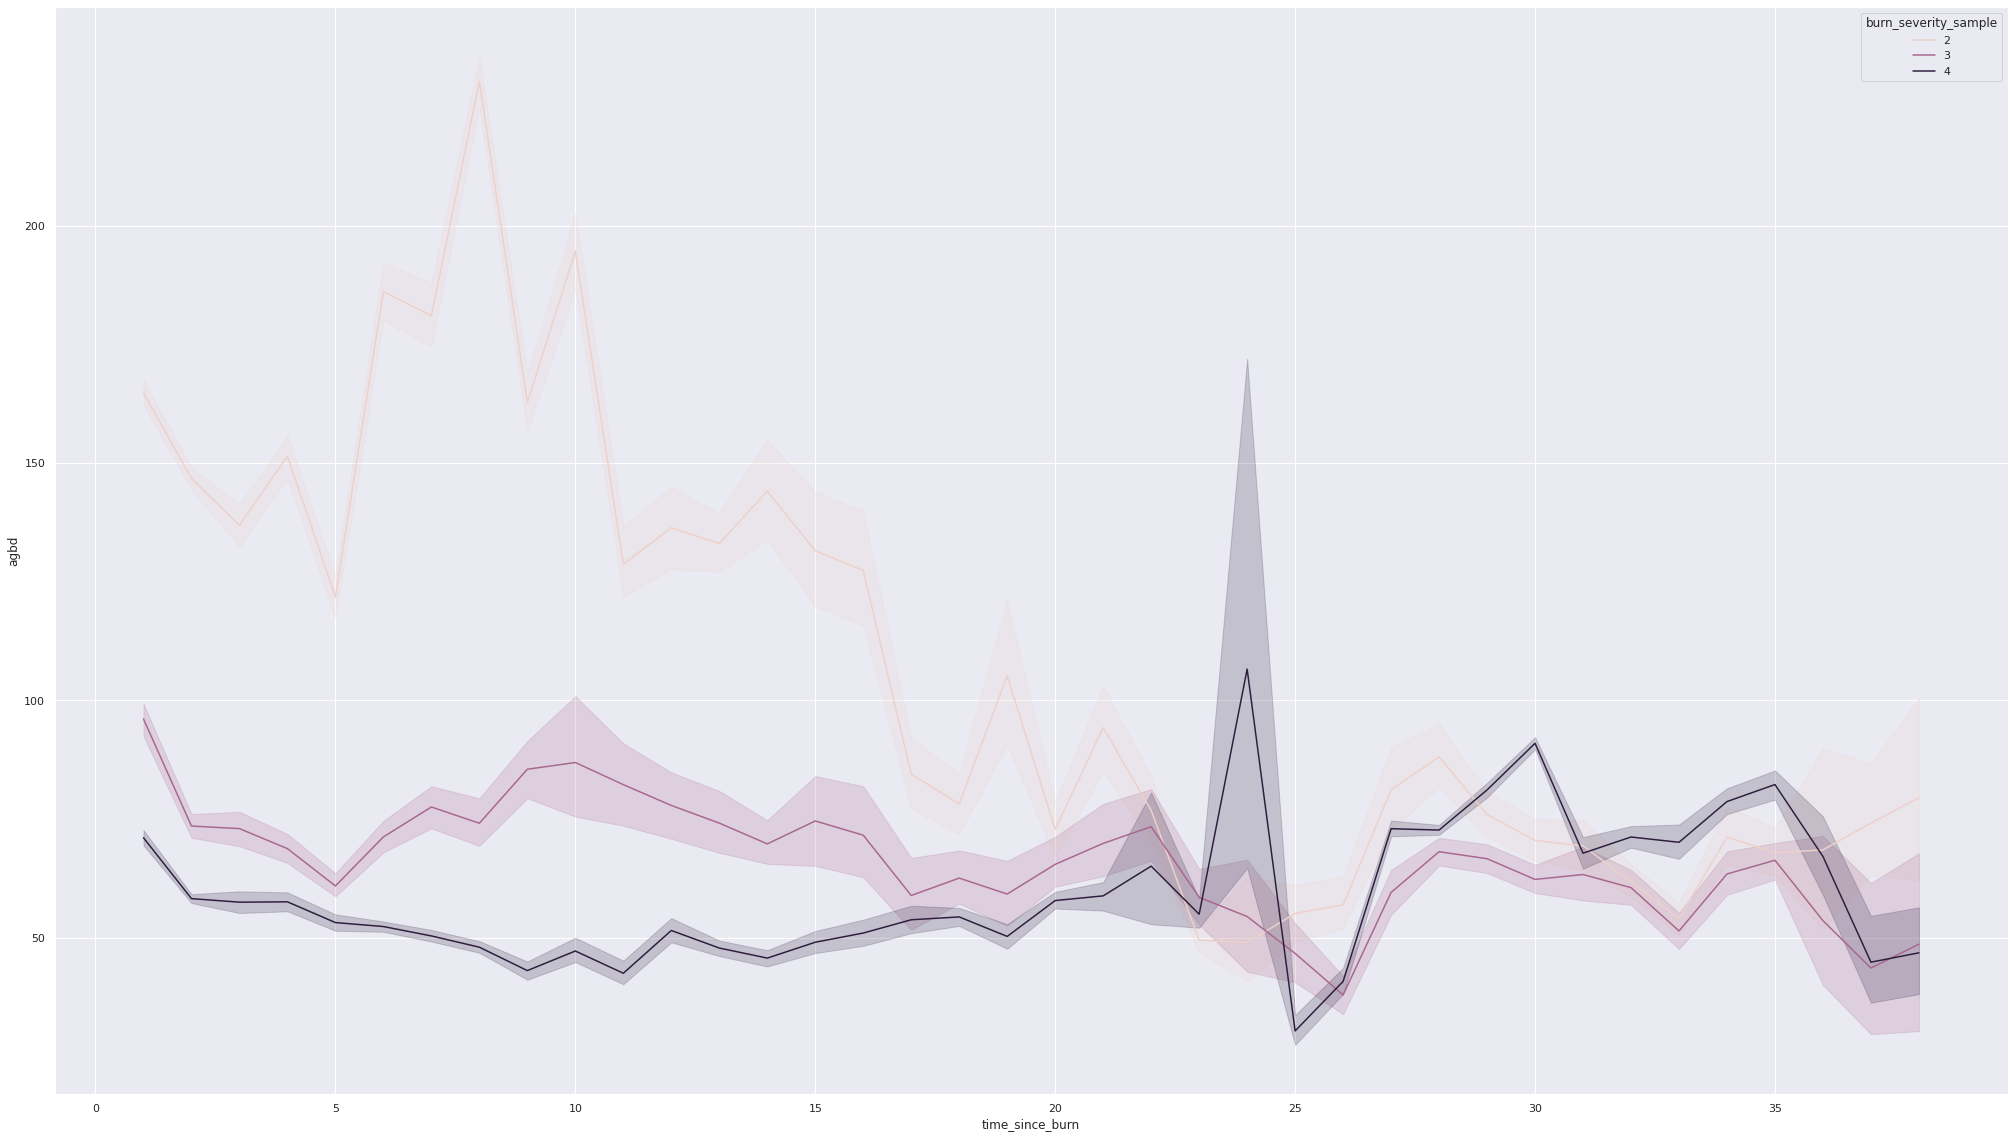

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(35, 20))
sns.lineplot(gedi_burn_perfect_match[gedi_burn_perfect_match.burn_severity_sample.isin([2, 3, 4])], x='time_since_burn', y='agbd', hue='burn_severity_sample')

### Do linear regression

In [37]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [56]:
gedi_burn_4 = gedi_burn_imperfect_match[gedi_burn_imperfect_match.burn_severity_sample == 4]
gedi_burn_4 = gedi_burn_4[gedi_burn_4.time_since_burn > 2]
model = sm.OLS(gedi_burn_4['agbd'], sm.add_constant(gedi_burn_4['time_since_burn'])).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   agbd   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1611.
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:21:55   Log-Likelihood:            -7.9415e+05
No. Observations:              144717   AIC:                         1.588e+06
Df Residuals:                  144715   BIC:                         1.588e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              52.2599      0.290    1

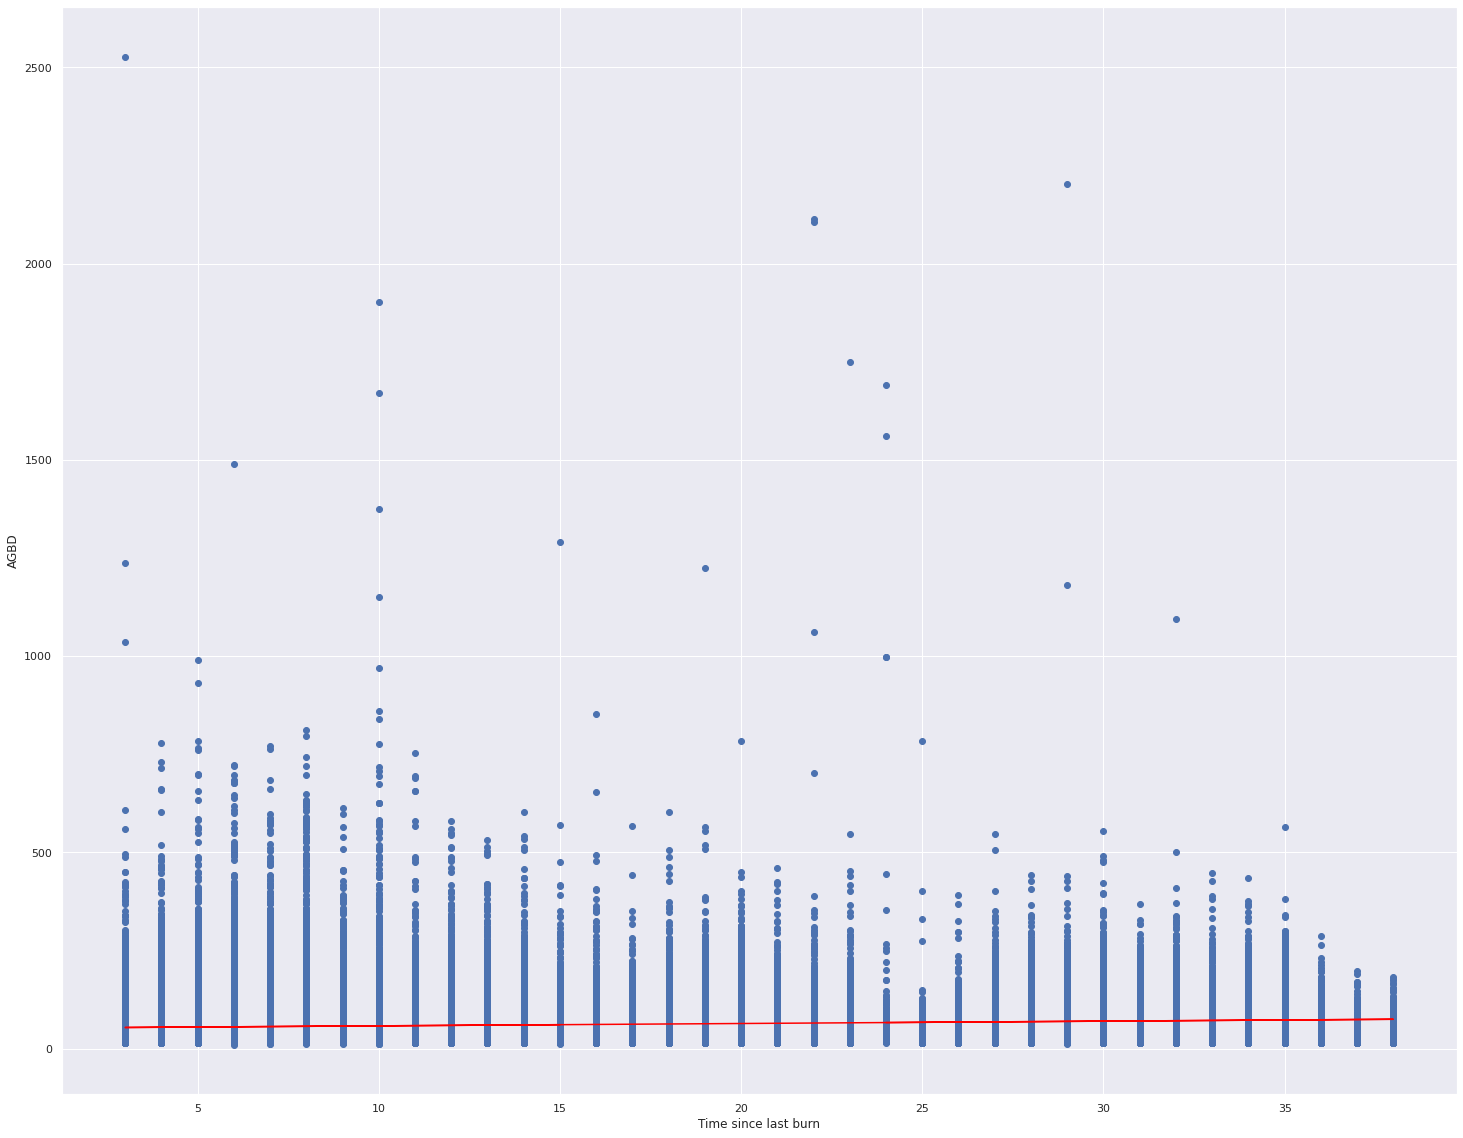

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(25, 20))
sc = plt.scatter(gedi_burn_4['time_since_burn'], gedi_burn_4['agbd'])#, c = pd.Categorical(master_climate['polygon_id']).codes)
plt.plot(gedi_burn_4['time_since_burn'], model.predict(), color='red')
plt.xlabel('Time since last burn')
plt.ylabel('AGBD')
#categories = [i for i in range(1,9)]
#handles, labels = sc.legend_elements()
#plt.legend(handles, categories, title='Polygon')
plt.show()

In [ ]:
gedi_burn_perfect_match.burn_severity_sample.unique()

gedi_burn_perfect_match.burn_severity_sample

In [ ]:
gedi_burn_perfect_match = gedi_burn_match[gedi_burn_match.burn_year_std == 0]
gedi_burn_perfect_match

Next, we need to get rid of all the shots that happened before the fires we're looking at.

In [ ]:
gedi_with_burn[gedi_with_burn.burn_severity_std == 0]

In [ ]:
samples[:, 0].reshape(1000, 9)

In [ ]:
count = 0
for x in samples:
    if x[0] != 0:
        print(count)
        print(x)
    count +=1

In [ ]:
new_gedi = sample_raster.sample_burn_raster(gedi[gedi.shot_number == 22790800300230951], 3)
new_gedi

In [ ]:
new_gedi.burn_severity_3x3

In [ ]:
x = np.array([2,3,1,1,1,1,1])
np.median(x)

In [ ]:
import numpy as np
x = np.arange(18)
x.shape = (2, 9)
print(x)
print(np.mean(x, axis=1))
print(np.std(x, axis=1))

In [ ]:
gedi_gpd = gpd.GeoDataFrame(gedi, geometry=gpd.points_from_xy(gedi.lon_lowestmode, gedi.lat_lowestmode), crs=4326)

In [ ]:
raster = rio.open('/maps/fire-regen/data/rasters/burn_mosaic.tif')

In [ ]:
fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent=[raster.bounds[0], raster.bounds[2], raster.bounds[1], raster.bounds[3]]
ax = rio.plot.show(raster, extent=extent, ax=ax, cmap='pink')

gedi_gpd.head(1000).plot(ax=ax)

In [ ]:
gedi_1000 = gedi_gpd.head(1000)

In [ ]:
coord_list = [(x,y) for x,y in zip(gedi_gpd['geometry'].x , gedi_gpd['geometry'].y)]

In [ ]:
samples = [x for x in raster.sample(coord_list)]

In [ ]:
gedi_gpd['severity'] = [x[0] for x in samples]

In [ ]:
gedi_gpd['year'] = [x[1] for x in samples]

In [ ]:
gedi_10 = gedi_gpd.head(10)

In [ ]:
gedi_gpd['gedi_year'] = pd.to_datetime(gedi_gpd.absolute_time, utc=True).dt.year

In [ ]:
gedi_gpd['gedi_year'] = pd.to_datetime(gedi_gpd.absolute_time, utc=True).dt.year
gedi_gpd['time_since_burn'] = gedi_gpd.gedi_year - gedi_gpd.year

In [ ]:
gedi_gpd.absolute_time

In [ ]:
gedi_gpd['gedi_year'] = pd.DatetimeIndex(gedi_gpd['absolute_time']).year

In [ ]:
severity_4 = gedi_gpd[(gedi_gpd.year != 0) & (gedi_gpd.severity == 1) & (gedi_gpd.time_since_burn > 0)]
severity_4.pft_class.unique()

In [ ]:
import seaborn as sns

sns.pointplot(severity_4[severity_4.pft_class == 6], x='time_since_burn', y='agbd')

In [ ]:
gedi_points = gedi_gpd[['lon_lowestmode', 'lat_lowestmode', 'shot_number']].values.tolist()

In [ ]:
gedi_points[0]

In [ ]:
gedi_points_ee = ee.FeatureCollection([ee.Feature(ee.Geometry.Point([x[0], x[1]]), {'shot_number': x[2]}) for x in gedi_points])

In [ ]:
burn_severity_ic = mtbs.get_burn_severity_data().sort('system:time_start', True)

In [ ]:
burn_mosaic = burn_severity_ic.mosaic()

In [ ]:
fc_point_samples = burn_mosaic.sampleRegions(gedi_points_ee, scale=30).getInfo()